In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [6]:
#hide
from fastai.vision.all import *
# from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

# 深入学习: 训练一个数字分类器

Having seen what it looks like to actually train a variety of models in Chapter 2, let’s now look under the hood and see exactly what is going on. We’ll start by using computer vision to introduce fundamental tools and concepts for deep learning.

在第二章我们已经看到了各种模型的训练是什么样的，现在我们来仔细看看到底发生了什么。我们将用计算机视觉来介绍深度学习中的各种基础工具和概念。

To be exact, we'll discuss the roles of arrays and tensors and of broadcasting, a powerful technique for using them expressively. We'll explain stochastic gradient descent (SGD), the mechanism for learning by updating weights automatically. We'll discuss the choice of a loss function for our basic classification task, and the role of mini-batches. We'll also describe the math that a basic neural network is actually doing. Finally, we'll put all these pieces together.

准确的说，我们将要讨论数组、张量和一种使用他们的强大技术 -- TODO:broadcasting:TODO。我们将会解释自动更新权重来学习的机制--随机梯度下降。我们还会讨论如何为我们的简单的分类任务挑选损失函数，以及TODO:mini-batches:TODO的作用。

In future chapters we’ll do deep dives into other applications as well, and see how these concepts and tools generalize. But this chapter is about laying foundation stones. To be frank, that also makes this one of the hardest chapters, because of how these concepts all depend on each other. Like an arch, all the stones need to be in place for the structure to stay up. Also like an arch, once that happens, it's a powerful structure that can support other things. But it requires some patience to assemble.

在后面的章节我们也将深入的讨论其他的应用，你会看到这些概念和方法都很通用。但是这个章节我们还是为了铺路。坦白的讲，由于所有的这些概念相互依赖的方式，使得本章成为最难的一章。就好像一个石桥，所有的石头都要放对位置才能让整体的结构不倒塌。同样像石桥，一旦你搭好了，它就是一个可以撑起很多其他东西的强大结构。但是搭建的过程是需要一些耐心的。

Let's begin. The first step is to consider how images are represented in a computer.

让我们开始吧。第一步我们来考虑图像是怎么在计算机中表示的。

## Pixels: The Foundations of Computer Vision

## 像素：计算机视觉的基础

In order to understand what happens in a computer vision model, we first have to understand how computers handle images. We'll use one of the most famous datasets in computer vision, [MNIST](https://en.wikipedia.org/wiki/MNIST_database), for our experiments. MNIST contains images of handwritten digits, collected by the National Institute of Standards and Technology and collated into a machine learning dataset by Yann Lecun and his colleagues. Lecun used MNIST in 1998 in [Lenet-5](http://yann.lecun.com/exdb/lenet/), the first computer system to demonstrate practically useful recognition of handwritten digit sequences. This was one of the most important breakthroughs in the history of AI.

为了理解在计算机视觉模型中发生了什么，我们首先得了解计算机是怎么处理的图像的。我们将使用在计算机视觉中最重要的数据集之一[MNIST](https://en.wikipedia.org/wiki/MNIST_database)来做我们的实验。MNIST包含了很多手写体的数字，它是由美国国家标准与技术研究院搜集并由杨立昆和他的同事们整理成可以供机器学习使用的数据集。1998年立昆在[Lenet-5](http://yann.lecun.com/exdb/lenet/)中使用了MNIST，这是第一个演示了有实用价值的可以识别手写数字序列的计算机系统。这在人工智能的历史上是最重要的突破之一。

## Sidebar: Tenacity and Deep Learning

# # 侧边栏: 坚韧和深度学习[机器翻译]

The story of deep learning is one of tenacity and grit by a handful of dedicated researchers. After early hopes (and hype!) neural networks went out of favor in the 1990's and 2000's, and just a handful of researchers kept trying to make them work well. Three of them, Yann Lecun, Yoshua Bengio, and Geoffrey Hinton, were awarded the highest honor in computer science, the Turing Award (generally considered the "Nobel Prize of computer science"), in 2018 after triumphing despite the deep skepticism and disinterest of the wider machine learning and statistics community.

深度学习的故事是少数敬业的研究者们坚韧不拔的故事之一。在早期的希望（和炒作！）之后，神经网络在20世纪90年代和2000年后就变得不温不火，只有少数研究者们还一直试图继续改进。杨立昆、Yoshua Bengio和Geoffrey Hinton三人，在广义的机器学习和统计学界的一片质疑和无视中最终取得胜利，于2018年被授予计算机科学中最高的荣誉，图灵奖（一般被认为是计算机科学届的诺贝尔奖）

Geoff Hinton has told of how even academic papers showing dramatically better results than anything previously published would be rejected by top journals and conferences, just because they used a neural network. Yann Lecun's work on convolutional neural networks, which we will study in the next section, showed that these models could read handwritten text—something that had never been achieved before. However, his breakthrough was ignored by most researchers, even as it was used commercially to read 10% of the checks in the US!

Geoff Hinton曾说，即使在学术论文中证明了结果明显优于之前发表的任何论文，也会因为仅仅是使用了神经网络而被顶级期刊和会议所拒绝。通过杨立昆在卷积神经网络上的研究表明这些模型可以识别手写的文本，这是以前从未实现的，这是我们下一章要学习的内容。然而他的这些研究突破被大多数研究者们忽略了，

In addition to these three Turing Award winners, there are many other researchers who have battled to get us to where we are today. For instance, Jurgen Schmidhuber (who many believe should have shared in the Turing Award) pioneered many important ideas, including working with his student Sepp Hochreiter on the long short-term memory (LSTM) architecture (widely used for speech recognition and other text modeling tasks, and used in the IMDb example in <<chapter_intro>>). Perhaps most important of all, Paul Werbos in 1974 invented back-propagation for neural networks, the technique shown in this chapter and used universally for training neural networks ([Werbos 1994](https://books.google.com/books/about/The_Roots_of_Backpropagation.html?id=WdR3OOM2gBwC)). His development was almost entirely ignored for decades, but today it is considered the most important foundation of modern AI.


除了这三位图灵奖得主之外，还有许多其他研究人员为把我们带到今天的位置而奋斗。例如，Jurgen Schmidhuber (许多人认为应该在图灵奖中分享) 开创了许多重要的想法，包括与他的学生Sepp Hochreiter合作进行长短期记忆 (LSTM) 架构 (广泛用于语音识别和其他文本建模任务，并在 <chapter_intro>> 中的IMDb示例中使用)。也许最重要的是，Paul Werbos在1974年发明了神经网络的反向传播技术，该技术在本章中展示并普遍用于训练神经网络 ([Werbos 1994]( https://books.google.com/books/about/The_Roots_of_Backpropagation.html?id=WdR3OOM2gBwC ))。几十年来，他的发展几乎完全被忽视，但今天，它被认为是现代人工智能最重要的基础。[机器翻译]

There is a lesson here for all of us! On your deep learning journey you will face many obstacles, both technical, and (even more difficult) posed by people around you who don't believe you'll be successful. There's one *guaranteed* way to fail, and that's to stop trying. We've seen that the only consistent trait amongst every fast.ai student that's gone on to be a world-class practitioner is that they are all very tenacious.

这里有一个教训给我们所有人!在你的深度学习之旅中，你将面临许多障碍，包括技术上的障碍，甚至是你周围不相信你会成功的人提出的障碍 (甚至更难)。有一种保证失败的方法，那就是停止尝试。我们已经看到，每一个后来成为世界级从业者的fast.ai学生唯一一致的特点是他们都非常顽强。[机器翻译]

## End sidebar

# # 结束侧边栏[机器翻译]

For this initial tutorial we are just going to try to create a model that can classify any image as a 3 or a 7. So let's download a sample of MNIST that contains images of just these digits:

在这个入门的教程中我们将尝试创建一个可以把任何图像分类为3和7的模型。让我们下载一个MNIST的样本，其中仅包含了这些数字。

In [8]:
path = untar_data(URLs.MNIST_SAMPLE)

In [9]:
#hide
Path.BASE_PATH = path

We can see what's in this directory by using `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more. One of its handy features is that, when printed, it displays the count of items, before listing the items themselves (if there are more than 10 items, it just shows the first few):



In [10]:
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Let's see what's inside the training set:

MNIST数据集遵循机器学习数据集的通用布局: 训练集和验证集 (和/或测试集) 的单独文件夹。让我们看看训练集中有什么:[机器翻译]

In [11]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the *labels* (or targets) in this dataset. Let's take a look in one of these folders (using `sorted` to ensure we all get the same order of files):

3s的文件夹，7s的文件夹。在机器学习的说法中，我们说 “3” 和 “7” 是这个数据集中的 * 标签 * (或目标)。让我们看看其中一个文件夹 (使用 “排序” 来确保我们都得到相同顺序的文件):[机器翻译]

In [12]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

As we might expect, it's full of image files. Let’s take a look at one now. Here’s an image of a handwritten number 3, taken from the famous MNIST dataset of handwritten numbers:

正如我们所料，它充满了图像文件。让我们现在看看一个。这是一张手写数字3的图像，取自著名的手写数字MNIST数据集:[机器翻译]

In [13]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

Here we are using the `Image` class from the *Python Imaging Library* (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.


这里我们使用的是 * Python图像库 * (PIL) 中的 “图像” 类，这是用于打开、操作和查看图像的最广泛使用的Python包。Jupyter知道PIL图像，所以它会自动为我们显示图像。[机器翻译]

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a *NumPy array* or a *PyTorch tensor*. For instance, here's what a section of the image looks like, converted to a NumPy array:

在计算机中，一切都表示为一个数字。要查看构成此图像的数字，我们必须将其转换为 * NumPy数组 * 或 * PyTorch张量 *。例如，以下是图像的一部分的外观，转换为NumPy数组:[机器翻译]

In [ ]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

The `4:10` indicates we requested the rows from index 4 (included) to 10 (not included) and the same for the columns. NumPy indexes from top to bottom and left to right, so this section is located in the top-left corner of the image. Here's the same thing as a PyTorch tensor:

“4:10” 表示我们请求从索引4 (包括) 到10 (不包括) 的行，列也是如此。NumPy索引从上到下，从左到右，所以这个部分位于图像的左上角。这和PyTorch张量是一样的:[机器翻译]

In [ ]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

我们可以对数组进行切片，只选择数字顶部的部分，然后使用Pandas DataFrame使用渐变对值进行颜色编码，这清楚地向我们展示了如何从像素值创建图像:[机器翻译]

In [14]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


<img width="453" id="output_pd_pixels" src="images/att_00058.png">

<Img width = "453" id = "output_pd_pixels" src = "images/att_00058.png">[机器翻译]

You can see that the background white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two. The entire image contains 28 pixels across and 28 pixels down, for a total of 768 pixels. (This is much smaller than an image that you would get from a phone camera, which has millions of pixels, but is a convenient size for our initial learning and experiments. We will build up to bigger, full-color images soon.)


您可以看到背景白色像素存储为数字0，黑色是数字255，灰色阴影介于两者之间。整个图像包含28个像素和28个像素，总共768个像素。(这比你从手机摄像头上获得的图像小得多，手机摄像头有数百万像素，但对于我们最初的学习和实验来说是一个方便的尺寸。我们将很快建立更大的全彩色图像。)[机器翻译]

So, now you've seen what an image looks like to a computer, let's recall our goal: create a model that can recognize 3s and 7s. How might you go about getting a computer to do that?


所以，现在你已经看到了图像在计算机上是什么样子，让我们回顾一下我们的目标: 创建一个能够识别3和7的模型。你怎么能让一台电脑来做这件事？[机器翻译]

> Warning: Stop and Think!: Before you read on, take a moment to think about how a computer might be able to recognize these two different digits. What kinds of features might it be able to look at? How might it be able to identify these features? How could it combine them together? Learning works best when you try to solve problems yourself, rather than just reading somebody else's answers; so step away from this book for a few minutes, grab a piece of paper and pen, and jot some ideas down…

> 警告: 停下来想想!: 在你继续阅读之前，花点时间想想计算机是如何识别这两个不同的数字的。它可以看到什么样的功能？它如何能够识别这些特征？它如何将它们结合在一起？当你试图自己解决问题时，学习效果最好，而不仅仅是阅读别人的答案; 所以离开这本书几分钟，抓起一张纸和一支笔，记下一些想法…[机器翻译]

## First Try: Pixel Similarity

# # 第一次尝试: 像素相似性[机器翻译]

So, here is a first idea: how about we find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give us two group averages, defining what we might call the "ideal" 3 and 7. Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. This certainly seems like it should be better than nothing, so it will make a good baseline.

所以，这里有一个第一个想法: 我们如何找到3的每个像素的平均像素值，然后对7做同样的事情。这将给我们两个组平均值，定义我们可以称之为 “理想” 3和7。然后，为了将图像分类为一个数字或另一个数字，我们看到图像与这两个理想数字中的哪一个最相似。这看起来肯定比没有好，所以它会成为一个好的基线。[机器翻译]

> jargon: Baseline: A simple model which you are confident should perform reasonably well. It should be very simple to implement, and very easy to test, so that you can then test each of your improved ideas, and make sure they are always better than your baseline. Without starting with a sensible baseline, it is very difficult to know whether your super-fancy models are actually any good. One good approach to creating a baseline is doing what we have done here: think of a simple, easy-to-implement model. Another good approach is to search around to find other people that have solved similar problems to yours, and download and run their code on your dataset. Ideally, try both of these!

> 行话: 基线: 一个你有信心的简单模型应该表现得相当好。它应该非常容易实现，也非常容易测试，这样你就可以测试你的每一个改进的想法，并确保它们总是比你的基线更好。如果没有一个合理的基线，很难知道你的超级花哨的模型是否真的有什么好的。创建基线的一个好方法是做我们在这里做的事情: 考虑一个简单、易于实现的模型。另一个好方法是四处搜索，找到解决了与你类似问题的其他人，并在你的数据集上下载和运行他们的代码。理想情况下，尝试这两个![机器翻译]

Step one for our simple model is to get the average of pixel values for each of our two groups. In the process of doing this, we will learn a lot of neat Python numeric programming tricks!


我们简单模型的第一步是获取我们两组中每个组的像素值的平均值。在做这个的过程中，我们会学到很多整齐的Python数值编程技巧![机器翻译]

Let's create a tensor containing all of our 3s stacked together. We already know how to create a tensor containing a single image. To create a tensor containing all the images in a directory, we will first use a Python list comprehension to create a plain list of the single image tensors.


让我们创建一个张量，包含我们所有的3s堆叠在一起。我们已经知道如何创建包含单个图像的张量。要创建一个包含目录中所有图像的张量，我们将首先使用Python列表理解来创建单个图像张量的普通列表。[机器翻译]

We will use Jupyter to do some little checks of our work along the way—in this case, making sure that the number of returned items seems reasonable:

我们将使用Jupyter对我们的工作进行一些小的检查-在这种情况下，确保返回的项目的数量似乎是合理的:[机器翻译]

In [17]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [21]:
Image.open(sevens[0]).shape

(28, 28)

> note: List Comprehensions: List and dictionary comprehensions are a wonderful feature of Python. Many Python programmers use them every day, including the authors of this book—they are part of "idiomatic Python." But programmers coming from other languages may have never seen them before. There are a lot of great tutorials just a web search away, so we won't spend a long time discussing them now. Here is a quick explanation and example to get you started. A list comprehension looks like this: `new_list = [f(o) for o in a_list if o>0]`. This will return every element of `a_list` that is greater than 0, after passing it to the function `f`. There are three parts here: the collection you are iterating over (`a_list`), an optional filter (`if o>0`), and something to do to each element (`f(o)`). It's not only shorter to write but way faster than the alternative ways of creating the same list with a loop.

> 注意: 列表理解: 列表和字典理解是Python的一个奇妙特性。许多Python程序员每天都在使用它们，包括本书的作者 -- 它们是 “惯用Python” 的一部分。但是来自其他语言的程序员可能从未见过他们。有很多很棒的教程只是一个网络搜索，所以我们现在不会花很长时间讨论它们。这里有一个快速的解释和例子让你开始。一个列表理解看起来像这样: 'new_list = [f(o) for o in a_list if o>0]'。这将返回 'a_list' 的每个元素大于0，在将其传递给函数 'f' 之后。这里有三个部分: 您正在迭代的集合 ('a_list')，可选过滤器 ('如果o>0')，以及每个元素的一些事情 ('f(o))')。它不仅写得更短，而且比用循环创建相同列表的替代方法要快得多。[机器翻译]

We'll also check that one of the images looks okay. Since we now have tensors (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's `show_image` function to display it:

我们还将检查其中一幅图像看起来是否正常。由于我们现在有张量 (Jupyter默认将打印为值)，而不是PIL图像 (Jupyter默认将显示为图像)，我们需要使用fastai的 'show_image' 函数来显示它:[机器翻译]

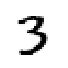

In [ ]:
show_image(three_tensors[1]);

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a *rank-3 tensor*. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called `stack` that we can use for this purpose.


对于每个像素位置，我们希望计算该像素强度的所有图像的平均值。为此，我们首先将列表中的所有图像组合成一个三维张量。描述这种张量最常见的方式是将其称为 * rank-3张量 *。我们经常需要将集合中的单个张量堆叠成单个张量。不出所料，PyTorch附带了一个名为 “堆栈” 的函数，我们可以用于此目的。[机器翻译]

Some operations in PyTorch, such as taking a mean, require us to *cast* our integer types to float types. Since we'll be needing this later, we'll also cast our stacked tensor to `float` now. Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.


PyTorch中的一些操作，如取平均值，需要我们 * cast * 我们的整数类型为float类型。由于我们稍后需要这个，我们现在也将把我们的堆叠张量转换为 “浮动”。在PyTorch中转换就像键入要转换到的类型的名称，并将其视为一种方法一样简单。[机器翻译]

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:


通常当图像是浮动时，像素值预计在0和1之间，所以我们在这里也将除以255:[机器翻译]


In [22]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens.shape

torch.Size([6265, 28, 28])

Perhaps the most important attribute of a tensor is its *shape*. This tells you the length of each axis. In this case, we can see that we have 6,131 images, each of size 28×28 pixels. There is nothing specifically about this tensor that says that the first axis is the number of images, the second is the height, and the third is the width—the semantics of a tensor are entirely up to us, and how we construct it. As far as PyTorch is concerned, it is just a bunch of numbers in memory.


也许张量最重要的属性是它的 * 形状 *。这将告诉您每个轴的长度。在这种情况下，我们可以看到我们有6,131个图像，每个大小为28 × 28像素。这个张量没有什么特别的意思，第一个轴是图像的数量，第二个轴是高度，第三个是宽度 -- 张量的语义完全取决于我们，以及我们如何构造它。就PyTorch而言，它只是记忆中的一堆数字。[机器翻译]

The *length* of a tensor's shape is its rank:

张量形状的 * 长度 * 是它的等级:[机器翻译]

In [ ]:
len(stacked_threes.shape)

3

It is really important for you to commit to memory and practice these bits of tensor jargon: _rank_ is the number of axes or dimensions in a tensor; _shape_ is the size of each axis of a tensor.


对你来说，致力于记忆和练习这些张量术语是非常重要的: _ rank _ 是张量中的轴或维度的数量; _ shape _ 是张量的每个轴的大小。[机器翻译]

> A: Watch out because the term "dimension" is sometimes used in two ways. Consider that we live in "three-dimensonal space" where a physical position can be described by a 3-vector `v`. But according to PyTorch, the attribute `v.ndim` (which sure looks like the "number of dimensions" of `v`) equals one, not three! Why? Because `v` is a vector, which is a tensor of rank one, meaning that it has only one _axis_ (even if that axis has a length of three). In other words, sometimes dimension is used for the size of an axis ("space is three-dimensional"); other times, it is used for the rank, or the number of axes ("a matrix has two dimensions"). When confused, I find it helpful to translate all statements into terms of rank, axis, and length, which are unambiguous terms.

> 答: 小心，因为术语 “维度” 有时以两种方式使用。考虑到我们生活在 “三维空间” 中，物理位置可以用3向量 “v” 来描述。但是根据PyTorch的说法，属性 'v.Ndm' (看起来确实像 'v' 的 “维度数”) 等于1，而不是3!为什么？因为 'v' 是一个向量，它是排名1的张量，这意味着它只有一个 _ 轴 _ (即使该轴的长度为3)。换句话说，有时维度用于轴的大小 (“空间是三维的”); 其他时候，它用于等级，或轴的数量 (“一个矩阵有两个维度”)。当困惑时，我发现将所有语句翻译成等级、轴和长度，这些都是明确的术语是有帮助的。[机器翻译]

We can also get a tensor's rank directly with `ndim`:

我们也可以直接用 'ndimm' 获得张量的排名:[机器翻译]

In [23]:
stacked_threes.ndim, type(stacked_threes)

(3, torch.Tensor)

Finally, we can compute what the ideal 3 looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.


最后，我们可以计算出理想3的样子。我们通过沿我们的堆叠，秩-3张量的维度0取平均值来计算所有图像张量的平均值。这是索引所有图像的维度。[机器翻译]

In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image. Here it is:

换句话说，对于每个像素位置，这将计算所有图像上该像素的平均值。结果将是每个像素位置的一个值，或单个图像。这里是:[机器翻译]

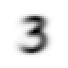

In [24]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

According to this dataset, this is the ideal number 3! (You may not like it, but this is what peak number 3 performance looks like.) You can see how it's very dark where all the images agree it should be dark, but it becomes wispy and blurry where the images disagree. 


根据这个数据集，这是理想的数字3!(你可能不喜欢它，但这就是3号峰值性能的样子。)你可以看到在所有图像都认为应该是黑暗的地方，它是多么的黑暗，但是在图像不同意的地方，它变得模糊和模糊。[机器翻译]


Let's do the same thing for the 7s, but put all the steps together at once to save some time:

让我们为7做同样的事情，但是同时把所有的步骤放在一起以节省一些时间:[机器翻译]

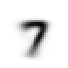

In [25]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Let's now pick an arbitrary 3 and measure its *distance* from our "ideal digits."  
现在我们来找一个具体的3并且计算它到我们的”完美3“之间的距离。  

> stop: Stop and Think!: How would you calculate how similar a particular image is to each of our ideal digits? Remember to step away from this book and jot down some ideas before you move on! Research shows that recall and understanding improves dramatically when you are engaged with the learning process by solving problems, experimenting, and trying new ideas yourself

>停下来想想：我们怎么计算一个特定的图片到我们所定义的完美的图片之间的距离？在继续往下看之前，先自己写写画画思考一下！研究表明，当您通过解决问题，进行实验和尝试新的想法参与学习过程时，回忆和理解会大大提高

Here's a sample 3:  
下面我们来挑一个3：

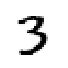

In [27]:
a_3 = stacked_threes[1]
show_image(a_3);

How can we determine its distance from our ideal 3? We can't just add up the differences between the pixels of this image and the ideal digit. Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal. That would be misleading! 

我们怎么计算它到我们的完美的3之间的距离呢？我们不能简单的把这两个3之间的每个像素的值都减一减再加起来，因为这些差有些是正的有些是负的，他们会互相抵消，比如一个图片有些地方颜色很重，有些地方颜色很浅就会导致他们和完美的3之间的距离是0。这样就走歪了!

To avoid this, there are two main ways data scientists measure distance in this context:

为了避免这种情况，数据科学家有两个主要的方法来应对这种场景：  

- Take the mean of the *absolute value* of differences (absolute value is the function that replaces negative values with positive values). This is called the *mean absolute difference* or *L1 norm*
- Take the mean of the *square* of differences (which makes everything positive) and then take the *square root* (which undoes the squaring). This is called the *root mean squared error* (RMSE) or *L2 norm*.

- 求所有差值的绝对值的平均值(求绝对值就是把负数转化成正数)，这称作 *mean absolute difference* 或者称为 *L1 norm*。
- 求所有差值的平方数的平均值(平方以后所有数也都变成正数了)，这称作 *root mean squared error* (RMSE) 或者称为 *L2 norm*

> important: It's Okay to Have Forgotten Your Math: In this book we generally assume that you have completed high school math, and remember at least some of it... But everybody forgets some things! It all depends on what you happen to have had reason to practice in the meantime. Perhaps you have forgotten what a _square root_ is, or exactly how they work. No problem! Any time you come across a maths concept that is not explained fully in this book, don't just keep moving on; instead, stop and look it up. Make sure you understand the basic idea, how it works, and why we might be using it. One of the best places to refresh your understanding is Khan Academy. For instance, Khan Academy has a great [introduction to square roots](https://www.khanacademy.org/math/algebra/x2f8bb11595b61c86:rational-exponents-radicals/x2f8bb11595b61c86:radicals/v/understanding-square-roots).

> 注意：如果你已经把数学给忘记了也没关系：在这本书里我们基本上假设你上过高中，至少还记得一点。。。不过每个人都忘掉不少！这取决你平时是不是有机会用到，也许你已经忘了平方根是啥玩意，或者根本不记得是什么原理。没关系！任何时候，你在这本书里碰到一个数学概念但是书里又没讲清楚的时候，不要再继续往下看了，你应该停下来and look it up。确定你能理解他基本思想，原理，并且知道为什么我们能这样用。可汗学院是最好的在任何时候都能帮助你想起来。比如，可汗学院有个非常棒的[平方根的介绍](https://www.khanacademy.org/math/algebra/x2f8bb11595b61c86:rational-exponents-radicals/x2f8bb11595b61c86:radicals/v/understanding-square-roots)。

Let's try both of these now:

来！现在我们两种方法都试一下：

In [28]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [ ]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

这两种方法中，3和完美的3比完美的7之间的距离小。所以在这个例子中我们的这个简易模型会给出正确的预测。

PyTorch already provides both of these as *loss functions*. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai):

PyTorch提供这些计算距离的方法，叫做*损失函数*。你可以在`torch.nn.functional`里找到，PyTorch团队推荐以F这个命名空间来导入这些函数。

In [ ]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Here `mse` stands for *mean squared error*, and `l1` refers to the standard mathematical jargon for *mean absolute value* (in math it's called the *L1 norm*).

这里`mse`代表*mean square error*，然后`l1`代表标准的数学术语

> S: Intuitively, the difference between L1 norm and mean squared error (MSE) is that the latter will penalize bigger mistakes more heavily than the former (and be more lenient with small mistakes).

> S: 直觉上，L1 norm和MSE的差异是，后者会比前者更加放大差异点(对小的差异点会更宽松)

> J: When I first came across this "L1" thingie, I looked it up to see what on earth it meant. I found on Google that it is a _vector norm_ using _absolute value_, so looked up _vector norm_ and started reading: _Given a vector space V over a field F of the real or complex numbers, a norm on V is a nonnegative-valued any function p: V → \[0,+∞) with the following properties: For all a ∈ F and all u, v ∈ V, p(u + v) ≤ p(u) + p(v)..._ Then I stopped reading. "Ugh, I'll never understand math!" I thought, for the thousandth time. Since then I've learned that every time these complex mathy bits of jargon come up in practice, it turns out I can replace them with a tiny bit of code! Like, the _L1 loss_ is just equal to `(a-b).abs().mean()`, where `a` and `b` are tensors. I guess mathy folks just think differently than me... I'll make sure in this book that every time some mathy jargon comes up, I'll give you the little bit of code it's equal to as well, and explain in common-sense terms what's going on.

> J: 当我第一次看到这个 “L1” 东西时，我查了一下，看看它到底是什么意思。我在Google上发现它是一个 _ 向量范数 _ using _ 绝对值 _，于是查了一下 _ 向量范数 _ 开始阅读: _ 给定实数或复数F域上的向量空间V，V上的范数是非负值任何函数p: V → \[0，∞)具有以下性质: 对于所有a ∈ F和所有u，v ∈ V，p(u v) ≤ p(u) p(v)._ 然后我停止阅读。“啊，我永远也不会懂数学!” 我想了第一千次。从那以后，我了解到，每当这些复杂的马西行话在实践中出现时，我就可以用一点点代码来代替它们!像，_ L1损失 _ 正好等于 '(a-b).abs().mean()，其中' a '和' b '是张量。我猜马西的人只是和我想法不同.我会在这本书里确保每次出现一些马西的行话，我都会给你一点点代码，用常识性的术语解释发生了什么。[机器翻译]

We just completed various mathematical operations on PyTorch tensors. If you've done some numeric programming in PyTorch before, you may recognize these as being similar to NumPy arrays. Let's have a look at those two very important data structures.

我们刚刚在PyTorch张量上完成了各种数学运算。如果您以前在PyTorch中做过一些数值编程，您可能会认为这些类似于NumPy数组。让我们看看这两个非常重要的数据结构。[机器翻译]

### NumPy Arrays and PyTorch Tensors

# NumPy数组和PyTorch张量[机器翻译]

[NumPy](https://numpy.org/) is the most widely used library for scientific and numeric programming in Python. It provides very similar functionality and a very similar API to that provided by PyTorch; however, it does not support using the GPU or calculating gradients, which are both critical for deep learning. Therefore, in this book we will generally use PyTorch tensors instead of NumPy arrays, where possible.


[NumPy]( https://numpy.org/ ) 是Python中最广泛使用的科学和数值编程库。它提供了与PyTorch非常相似的功能和非常相似的API; 但是，它不支持使用GPU或计算梯度，这对深度学习至关重要。因此，在本书中，我们将尽可能使用PyTorch tensor而不是NumPy数组。[机器翻译]

(Note that fastai adds some features to NumPy and PyTorch to make them a bit more similar to each other. If any code in this book doesn't work on your computer, it's possible that you forgot to include a line like this at the start of your notebook: `from fastai.vision.all import *`.)


(请注意，fastai为NumPy和PyTorch添加了一些特性，使它们彼此更加相似。如果这本书里的任何代码在你的电脑上不起作用，你可能忘记在笔记本的开头加上这样一行: “来自fastai”。愿景。所有导入 * '。)[机器翻译]

But what are arrays and tensors, and why should you care?

但是什么是数组和张量，你为什么要关心？[机器翻译]

Python is slow compared to many languages. Anything fast in Python, NumPy, or PyTorch is likely to be a wrapper for a compiled object written (and optimized) in another language—specifically C. In fact, **NumPy arrays and PyTorch tensors can finish computations many thousands of times faster than using pure Python.**


与许多语言相比，Python很慢。Python，NumPy或PyTorch中的任何快速内容都可能是用另一种语言编写 (并优化) 的编译对象的包装器-特别是C。事实上，* * NumPy数组和PyTorch tensor可以比使用纯Python更快地完成数千倍的计算。* *[机器翻译]

A NumPy array is a multidimensional table of data, with all items of the same type. Since that can be any type at all, they can even be arrays of arrays, with the innermost arrays potentially being different sizes—this is called a "jagged array." By "multidimensional table" we mean, for instance, a list (dimension of one), a table or matrix (dimension of two), a "table of tables" or "cube" (dimension of three), and so forth. If the items are all of some simple type such as integer or float, then NumPy will store them as a compact C data structure in memory. This is where NumPy shines. NumPy has a wide variety of operators and methods that can run computations on these compact structures at the same speed as optimized C, because they are written in optimized C.


NumPy数组是一个多维数据表，所有项目的类型相同。由于这可以是任何类型，它们甚至可以是数组数组，其中最内部的数组可能具有不同的大小-这称为 “锯齿状数组”。我们所说的 “多维表” 是指，例如，一个列表 (维度为1)，一个表或矩阵 (维度为2)，“表表” 或 “多维数据集” (三维)，依此类推。如果这些项目都是一些简单的类型，比如integer或float，那么NumPy会将它们作为一个紧凑的C数据结构存储在内存中。这就是NumPy闪耀的地方。NumPy有各种各样的运算符和方法，可以以与优化C相同的速度在这些紧凑结构上运行计算，因为它们是用优化C编写的。[机器翻译]

A PyTorch tensor is nearly the same thing as a NumPy array, but with an additional restriction that unlocks some additional capabilities. It's the same in that it, too, is a multidimensional table of data, with all items of the same type. However, the restriction is that a tensor cannot use just any old type—it has to use a single basic numeric type for all components. For example, a PyTorch tensor cannot be jagged. It is always a regularly shaped multidimensional rectangular structure.


PyTorch张量几乎与NumPy数组相同，但有一个额外的限制，可以解锁一些额外的功能。同样的，它也是一个多维数据表，所有项目都是相同类型的。但是，限制是张量不能只使用任何旧类型-它必须为所有组件使用单个基本数字类型。例如，PyTorch张量不能是锯齿状的。它总是一个规则形状的多维矩形结构。[机器翻译]

The vast majority of methods and operators supported by NumPy on these structures are also supported by PyTorch, but PyTorch tensors have additional capabilities. One major capability is that these structures can live on the GPU, in which case their computation will be optimized for the GPU and can run much faster (given lots of values to work on). In addition, PyTorch can automatically calculate derivatives of these operations, including combinations of operations. As you'll see, it would be impossible to do deep learning in practice without this capability.


NumPy在这些结构上支持的绝大多数方法和运算符也由PyTorch支持，但PyTorch张量具有额外的能力。一个主要功能是这些结构可以在GPU上运行，在这种情况下，它们的计算将针对GPU进行优化，并且可以运行得更快 (给定大量值)。此外，PyTorch可以自动计算这些操作的导数，包括操作的组合。正如你将看到的，如果没有这种能力，就不可能在实践中进行深度学习。[机器翻译]

> S: If you don't know what C is, don't worry as you won't need it at all. In a nutshell, it's a low-level  (low-level means more similar to the language that computers use internally) language that is very fast compared to Python. To take advantage of its speed while programming in Python, try to avoid as much as possible writing loops, and replace them by commands that work directly on arrays or tensors.


如果你不知道什么是C，不要担心，因为你根本不需要它。简而言之，它是一种低级 (低级意味着更类似于计算机内部使用的语言) 语言，与Python相比速度非常快。为了在Python中编程时利用它的速度，尽量避免写循环，用直接在数组或张量上工作的命令来代替它们。[机器翻译]

Perhaps the most important new coding skill for a Python programmer to learn is how to effectively use the array/tensor APIs. We will be showing lots more tricks later in this book, but here's a summary of the key things you need to know for now.

对于Python程序员来说，最重要的新编码技能可能是如何有效地使用array/tensor api。我们将在本书的后面展示更多的技巧，但是这里有一个你现在需要知道的关键事情的总结。[机器翻译]

To create an array or tensor, pass a list (or list of lists, or list of lists of lists, etc.) to `array()` or `tensor()`:

要创建数组或张量，请将列表 (或列表列表，或列表列表等) 传递给 “array()” 或 “tensor()”:[机器翻译]

In [ ]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [ ]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

All the operations that follow are shown on tensors, but the syntax and results for NumPy arrays is identical.


接下来的所有操作都显示在tensor上，但NumPy数组的语法和结果是相同的。[机器翻译]

You can select a row (note that, like lists in Python, tensors are 0-indexed so 1 refers to the second row/column):

您可以选择一行 (请注意，与Python中的列表一样，张量是0索引的，因此1指的是第二行/列):[机器翻译]

In [ ]:
tns[1]

tensor([4, 5, 6])

or a column, by using `:` to indicate *all of the first axis* (we sometimes refer to the dimensions of tensors/arrays as *axes*):

或者一列，通过使用 “:” 来表示 * 所有第一个轴 * (我们有时将张量/数组的尺寸称为 * 轴 *):[机器翻译]

In [ ]:
tns[:,1]

tensor([2, 5])

You can combine these with Python slice syntax (`[start:end]` with `end` being excluded) to select part of a row or column:

您可以将这些与Python切片语法 ('[start:end]' 和 'end' 被排除) 相结合，以选择行或列的一部分:[机器翻译]

In [ ]:
tns[1,1:3]

tensor([5, 6])

And you can use the standard operators such as `+`, `-`, `*`, `/`:

您可以使用标准运算符，如 ''，'-'，'*'，'/':[机器翻译]

In [ ]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

Tensors have a type:

张量有一个类型:[机器翻译]

In [ ]:
tns.type()

'torch.LongTensor'

And will automatically change type as needed, for example from `int` to `float`:

并将根据需要自动更改类型，例如从 “int” 更改为 “float”:[机器翻译]

In [ ]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

So, is our baseline model any good? To quantify this, we must define a metric.

那么，我们的基线模型有什么好处吗？要量化这一点，我们必须定义一个度量。[机器翻译]

## Computing Metrics Using Broadcasting

# # 使用广播计算指标[机器翻译]

Recall that a metric is a number that is calculated based on the predictions of our model, and the correct labels in our dataset, in order to tell us how good our model is. For instance, we could use either of the functions we saw in the previous section, mean squared error, or mean absolute error, and take the average of them over the whole dataset. However, neither of these are numbers that are very understandable to most people; in practice, we normally use *accuracy* as the metric for classification models.


回想一下，度量是基于我们模型的预测和数据集中的正确标签计算的数字，以告诉我们我们的模型有多好。例如，我们可以使用上一节中看到的函数中的任何一个，均方误差或平均绝对误差，并在整个数据集上取它们的平均值。然而，这两个数字对大多数人来说都不是很容易理解的; 实际上，我们通常使用 * 准确性 * 作为分类模型的度量。[机器翻译]

As we've discussed, we want to calculate our metric over a *validation set*. This is so that we don't inadvertently overfit—that is, train a model to work well only on our training data. This is not really a risk with the pixel similarity model we're using here as a first try, since it has no trained components, but we'll use a validation set anyway to follow normal practices and to be ready for our second try later.


正如我们所讨论的，我们希望在 * 验证集 * 上计算我们的指标。这样我们就不会无意中过度匹配 -- 也就是说，训练一个模型只对我们的训练数据有效。对于我们在这里使用的像素相似性模型来说，这并不是一个真正的风险，因为它没有经过训练的组件，但是无论如何，我们将使用验证集来遵循正常的实践，并为以后的第二次尝试做好准备。[机器翻译]

To get a validation set we need to remove some of the data from training entirely, so it is not seen by the model at all. As it turns out, the creators of the MNIST dataset have already done this for us. Do you remember how there was a whole separate directory called *valid*? That's what this directory is for!


为了获得验证集，我们需要从训练中完全删除一些数据，所以模型根本看不到这些数据。事实证明，MNIST数据集的创建者已经为我们做到了这一点。你还记得怎么有一个单独的目录称为 * 有效 *？这就是这个目录的用途![机器翻译]

So to start with, let's create tensors for our 3s and 7s from that directory. These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image:

首先，让我们从该目录为3和7创建张量。这些是我们将用来计算测量我们首次尝试模型质量的度量的张量，它测量与理想图像的距离:[机器翻译]

In [ ]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

It's good to get in the habit of checking shapes as you go. Here we see two tensors, one representing the 3s validation set of 1,010 images of size 28×28, and one representing the 7s validation set of 1,028 images of size 28×28.


养成边走边检查形状的习惯是件好事。这里我们看到两个张量，一个代表1,010张28 × 28大小的图像的3s验证集，一个代表1,028张28 × 28大小的图像的7s验证集。[机器翻译]

We ultimately want to write a function, `is_3`, that will decide if an arbitrary image is a 3 or a 7. It will do this by deciding which of our two "ideal digits" this arbitrary image is closer to. For that we need to define a notion of distance—that is, a function that calculates the distance between two images.


我们最终想写一个函数，“is_3”，它将决定任意图像是3还是7。它将通过决定这个任意图像更接近我们的两个 “理想数字” 中的哪一个来实现这一点。为此，我们需要定义一个距离的概念 -- 也就是说，一个计算两个图像之间距离的函数。[机器翻译]

We can write a simple function that calculates the mean absolute error using an experssion very similar to the one we wrote in the last section:

我们可以编写一个简单的函数，使用一个与我们在最后一节中写的非常相似的表达式来计算平均绝对误差:[机器翻译]

In [ ]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

This is the same value we previously calculated for the distance between these two images, the ideal 3 `mean_3` and the arbitrary sample 3 `a_3`, which are both single-image tensors with a shape of `[28,28]`.


这是我们之前为这两幅图像之间的距离计算的相同值，理想3 'mean_3' 和任意样本3 'a_3'，两者都是形状为 '[28,28]' 的单像张量。[机器翻译]

But in order to calculate a metric for overall accuracy, we will need to calculate the distance to the ideal 3 for _every_ image in the validation set. How do we do that calculation? We could write a loop over all of the single-image tensors that are stacked within our validation set tensor, `valid_3_tens`, which has a shape of `[1010,28,28]` representing 1,010 images. But there is a better way.


但是为了计算总体精度的度量，我们需要计算验证集中 _ 每个 _ 图像到理想3的距离。我们如何进行计算？我们可以在我们的验证集张量中堆叠的所有单图像张量上写一个循环，'valid_3_tens'，其形状为 '[1010，28，28]' 代表1,010个图像。但是有更好的方法。[机器翻译]

Something very interesting happens when we take this exact same distance function, designed for comparing two single images, but pass in as an argument `valid_3_tens`, the tensor that represents the 3s validation set:

当我们使用这个完全相同的距离函数时，会发生一些非常有趣的事情，该函数是为比较两个单个图像而设计的，但是作为参数 “valid_3_tens” 传入，即表示3s验证集的张量:[机器翻译]

In [ ]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1050, 0.1526, 0.1186,  ..., 0.1122, 0.1170, 0.1086]),
 torch.Size([1010]))

Instead of complaining about shapes not matching, it returned the distance for every single image as a vector (i.e., a rank-1 tensor) of length 1,010 (the number of 3s in our validation set). How did that happen?


它不是抱怨形状不匹配，而是返回每个图像的距离作为向量 (i。e.，一个等级-1张量)，长度为1,010 (我们的验证集中3s的数量)。怎么会这样？[机器翻译]

Take another look at our function `mnist_distance`, and you'll see we have there the subtraction `(a-b)`. The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use *broadcasting*. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. Broadcasting is an important capability that makes tensor code much easier to write.


再看看我们的函数 'mnist_distance'，你会看到我们有减法 '(a-b)'。魔术是PyTorch，当它试图在两个不同等级的张量之间进行简单的减法运算时，将使用 * 广播 *。也就是说，它将自动扩展具有较小等级的张量，使其具有与具有较大等级的张量相同的大小。广播是一种重要的能力，它使tensor代码更容易编写。[机器翻译]

After broadcasting so the two argument tensors have the same rank, PyTorch applies its usual logic for two tensors of the same rank: it performs the operation on each corresponding element of the two tensors, and returns the tensor result. For instance:

在广播使得两个自变量张量具有相同的秩后，PyTorch对相同秩的两个张量应用其通常的逻辑: 它对两个张量的每个相应元素执行操作，并返回张量结果。例如:[机器翻译]

In [ ]:
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

So in this case, PyTorch treats `mean3`, a rank-2 tensor representing a single image, as if it were 1,010 copies of the same image, and then subtracts each of those copies from each 3 in our validation set. What shape would you expect this tensor to have? Try to figure it out yourself before you look at the answer below:

所以在这种情况下，PyTorch将 'mean3'，一个代表单个图像的rank-2张量，好像它是同一图像的1,010个副本，然后从我们的验证集中的每个3中减去每个副本。你希望这个张量有什么形状？在你看下面的答案之前，试着自己弄清楚:[机器翻译]

In [ ]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

We are calculating the difference between our "ideal 3" and each of the 1,010 3s in the validation set, for each of 28×28 images, resulting in the shape `[1010,28,28]`.


我们正在计算我们的 “理想3” 和验证集中每个1,010 3之间的差异，对于每个28 × 28图像，导致形状 '[1010，28,28]'。[机器翻译]

There are a couple of important points about how broadcasting is implemented, which make it valuable not just for expressivity but also for performance:


关于广播是如何实现的，有几个要点，这使得它不仅对表现力有价值，而且对性能也有价值:[机器翻译]

- PyTorch doesn't *actually* copy `mean3` 1,010 times. It *pretends* it were a tensor of that shape, but doesn't actually allocate any additional memory
- It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).


-PyTorch不 * 实际上 * 复制 'mean3' 1,010次。它 * 假装 * 它是那个形状的张量，但实际上没有分配任何额外的内存
-它在C中执行整个计算 (或者，如果您在CUDA中使用GPU，则相当于GPU上的C)，比纯Python快数万倍 (在GPU上速度高达数百万倍!)。[机器翻译]

This is true of all broadcasting and elementwise operations and functions done in PyTorch. *It's the most important technique for you to know to create efficient PyTorch code.*


在PyTorch中完成的所有广播和elementwise操作和功能都是如此。* 这是创建高效PyTorch代码的最重要的技术。*[机器翻译]

Next in `mnist_distance` we see `abs`. You might be able to guess now what this does when applied to a tensor. It applies the method to each individual element in the tensor, and returns a tensor of the results (that is, it applies the method "elementwise"). So in this case, we'll get back 1,010 absolute values.


接下来在 'mnist_distance' 中我们看到 'abs'。你现在可以猜测当应用于张量时会做什么。它将方法应用于张量中的每个单个元素，并返回结果的张量 (即，它应用方法 “elementwise”)。所以在这种情况下，我们会得到1,010的绝对值。[机器翻译]

Finally, our function calls `mean((-1,-2))`. The tuple `(-1,-2)` represents a range of axes. In Python, `-1` refers to the last element, and `-2` refers to the second-to-last. So in this case, this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor. The last two axes are the horizontal and vertical dimensions of an image. After taking the mean over the last two axes, we are left with just the first tensor axis, which indexes over our images, which is why our final size was `(1010)`. In other words, for every image, we averaged the intensity of all the pixels in that image.


最后，我们的函数调用 'mean((-1，-2等)'。元组 “(-1，-2)” 表示轴的范围。在Python中，“-1” 是指最后一个元素，“-2” 是指倒数第二个元素。因此，在这种情况下，这告诉PyTorch，我们希望在张量的最后两个轴索引的值上取平均值范围。最后两个轴是图像的水平和垂直尺寸。在最后两个轴上取平均值后，我们只剩下第一个张量轴，它索引了我们的图像，这就是为什么我们的最终尺寸是 '(1010)'。换句话说，对于每个图像，我们平均该图像中所有像素的强度。[机器翻译]

We'll be learning lots more about broadcasting throughout this book, especially in <<chapter_foundations>>, and will be practicing it regularly too.


我们将在本书中学习更多关于广播的知识，特别是在 <<chapter_foundations>> 中，并将定期练习。[机器翻译]

We can use `mnist_distance` to figure out whether an image is a 3 or not by using the following logic: if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3. This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:

我们可以使用 'mnist_distance' 通过以下逻辑来判断图像是否是3: 如果所讨论的数字和理想3之间的距离小于理想7之间的距离，那么它就是3。该函数将自动进行广播并按元素应用，就像所有PyTorch函数和运算符一样:[机器翻译]

In [ ]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

Let's test it on our example case:

让我们在我们的示例案例中测试它:[机器翻译]

In [ ]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Note that when we convert the Boolean response to a float, we get `1.0` for `True` and `0.0` for `False`. Thanks to broadcasting, we can also test it on the full validation set of 3s:

请注意，当我们将布尔响应转换为浮点时，我们得到 '1.0' 表示 'true'，'0.0' 表示 'false'。感谢广播，我们还可以在3s的完整验证集上进行测试:[机器翻译]

In [ ]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

Now we can calculate the accuracy for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s:

现在，我们可以通过计算所有3s的函数的平均值和所有7s的逆函数来计算3s和7s的精度:[机器翻译]

In [ ]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

This looks like a pretty good start! We're getting over 90% accuracy on both 3s and 7s, and we've seen how to define a metric conveniently using broadcasting.


这看起来是一个很好的开始!我们在3s和7s上都获得了超过90% 的准确率，并且我们已经了解了如何使用广播方便地定义度量标准。[机器翻译]

But let's be honest: 3s and 7s are very different-looking digits. And we're only classifying 2 out of the 10 possible digits so far. So we're going to need to do better!


但老实说: 3s和7s是非常不同的数字。到目前为止，我们只对10个可能的数字中的2个进行了分类。所以我们需要做得更好![机器翻译]

To do better, perhaps it is time to try a system that does some real learning—that is, that can automatically modify itself to improve its performance. In other words, it's time to talk about the training process, and SGD.

为了做得更好，也许是时候尝试一个真正学习的系统了 -- 也就是说，它可以自动修改自己来提高性能。换句话说，是时候谈论训练过程和SGD了。[机器翻译]

## Stochastic Gradient Descent (SGD)

# # 随机梯度下降 (SGD)[机器翻译]

Do you remember the way that Arthur Samuel described machine learning, which we quoted in <<chapter_intro>>?


你还记得我们在 <chapter_intro>> 中引用的Arthur Samuel描述机器学习的方式吗？[机器翻译]

> : Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.


>: 假设我们安排了一些自动方法来测试任何当前权重分配在实际性能方面的有效性，并提供了一种改变权重分配的机制，以便最大化性能。我们不需要深入了解这种程序的细节，就可以看到它可以完全自动化，并且看到如此编程的机器可以从其经验中 “学习”。[机器翻译]

As we discussed, this is the key to allowing us to have a model that can get better and better—that can learn. But our pixel similarity approach does not really do this. We do not have any kind of weight assignment, or any way of improving based on testing the effectiveness of a weight assignment. In other words, we can't really improve our pixel similarity approach by modifying a set of parameters. In order to take advantage of the power of deep learning, we will first have to represent our task in the way that Arthur Samuel described it.


正如我们所讨论的，这是让我们有一个可以变得越来越好的模型的关键 -- 可以学习。但是我们的像素相似性方法并没有真正做到这一点。我们没有任何种类的权重分配，也没有任何基于测试权重分配有效性的改进方法。换句话说，我们不能通过修改一组参数来真正改进我们的像素相似性方法。为了利用深度学习的力量，我们首先必须用亚瑟 · 塞缪尔描述的方式来代表我们的任务。[机器翻译]

Instead of trying to find the similarity between an image and an "ideal image," we could instead look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category. For instance, pixels toward the bottom right are not very likely to be activated for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. This can be represented as a function and set of weight values for each possible category—for instance the probability of being the number 8:


我们可以看看每个单独的像素，并为每个像素提出一组权重，而不是试图找出图像和 “理想图像” 之间的相似性，这样，对于特定类别，最高权重与最可能是黑色的像素相关联。例如，对于7来说，右下角的像素不太可能被激活，所以它们对于7来说应该具有较低的权重，但它们很可能会被激活8，所以他们应该有一个8的高权重。这可以表示为每个可能类别的函数和一组权重值-例如数字8的概率:[机器翻译]

```
def pr_eight(x,w) = (x*w).sum()
```

'''
Def pr_eight(x，w) = (x * w).sum()
'''[机器翻译]

Here we are assuming that `x` is the image, represented as a vector—in other words, with all of the rows stacked up end to end into a single long line. And we are assuming that the weights are a vector `w`. If we have this function, then we just need some way to update the weights to make them a little bit better. With such an approach, we can repeat that step a number of times, making the weights better and better, until they are as good as we can make them.


在这里，我们假设 “x” 是图像，表示为向量 -- 换句话说，所有的行从头到尾堆叠成一条长线。我们假设权重是向量 'w'。如果我们有这个功能，那么我们只需要一些方法来更新权重，使它们更好一点。有了这种方法，我们可以多次重复这一步，使重量越来越好，直到它们尽可能好。[机器翻译]

We want to find the specific values for the vector `w` that causes the result of our function to be high for those images that are actually 8s, and low for those images that are not. Searching for the best vector `w` is a way to search for the best function for recognising 8s. (Because we are not yet using a deep neural network, we are limited by what our function can actually do—we are going to fix that constraint later in this chapter.) 


我们想找到矢量 “w” 的特定值，这使得我们的函数的结果对于那些实际上是8的图像来说是高的，对于那些不是的图像来说是低的。搜索最佳矢量 “w” 是一种搜索识别8s的最佳功能的方法。(因为我们还没有使用深度神经网络，所以我们受到函数实际功能的限制 -- 我们将在本章后面修复这个限制。)[机器翻译]

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:


更具体地说，以下是我们将需要的步骤，将此函数转换为机器学习分类器:[机器翻译]

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

1. * 初始化 * 权重。
1.对于每个图像，使用这些权重来 * 预测 * 它看起来是3还是7。
1.基于这些预测，计算模型有多好 (它的 * 损失 *)。
1.计算 * 梯度 *，它衡量每个权重，改变权重会如何改变损失
1. * 步骤 * (即更改) 基于该计算的所有权重。
1.返回步骤2，并 * 重复 * 该过程。
1.迭代，直到您决定 * 停止 * 训练过程 (例如，因为模型足够好或者您不想再等了)。[机器翻译]

These seven steps, illustrated in <<gradient_descent>>, are the key to the training of all deep learning models. That deep learning turns out to rely entirely on these steps is extremely surprising and counterintuitive. It's amazing that this process can solve such complex problems. But, as you'll see, it really does!

这七个步骤，如 <<gradient_descent>> 所示，是所有深度学习模型训练的关键。深度学习完全依赖这些步骤是非常令人惊讶和违反直觉的。令人惊奇的是，这个过程能够解决如此复杂的问题。但是，正如你将看到的，它真的![机器翻译]

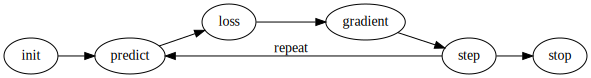

In [ ]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

There are many different ways to do each of these seven steps, and we will be learning about them throughout the rest of this book. These are the details that make a big difference for deep learning practitioners, but it turns out that the general approach to each one generally follows some basic principles. Here are a few guidelines:


有许多不同的方法来完成这七个步骤中的每一个，我们将在本书的其余部分学习它们。这些细节对深度学习从业者来说有很大的不同，但事实证明，每种方法的一般方法通常遵循一些基本原则。以下是一些指导方针:[机器翻译]

- Initialize:: We initialize the parameters to random values. This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.
- Loss:: This is what Samuel referred to when he spoke of *testing the effectiveness of any current weight assignment in terms of actual performance*. We need some function that will return a number that is small if the performance of the model is good (the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention).
- Step:: A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating *gradients*. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
- Stop:: Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. This is where that decision is applied. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.

-Initialize:: 我们将参数初始化为随机值。这听起来可能令人惊讶。我们当然还有其他选择，例如将它们初始化为该类别的像素被激活的次数百分比-但是因为我们已经知道我们有一个例程来提高这些权重，事实证明，从随机权重开始工作非常好。
-损失:: 这是塞缪尔在谈到 * 测试任何当前重量分配在实际性能方面的有效性时提到的 *。我们需要一些函数，如果模型的性能良好，它将返回一个小的数字 (标准方法是将小的损失视为好的，将大的损失视为坏的，虽然这只是一个惯例)。
-步骤:: 一个简单的方法来判断体重是应该增加一点还是减少一点，就是试一试: 增加一点体重，看看损失是上升还是下降。一旦你找到了正确的方向，你就可以多改变一点，少改变一点，直到你找到一个有效的量。然而，这是缓慢的!正如我们将看到的，微积分的魔力允许我们直接计算出改变每个重量的方向，大致是多少，而不必尝试所有这些微小的改变。这样做的方法是通过计算 * 梯度 *。这只是一个性能优化，我们也可以通过使用较慢的手动过程获得完全相同的结果。
-Stop:: 一旦我们决定了要训练模型多少次 (在前面的列表中给出了一些建议)，我们就应用了这个决定。这就是该决定的适用地点。对于我们的数字分类器，我们会继续训练，直到模型的准确性开始变得更差，或者我们没有时间了。[机器翻译]

Before applying these steps to our image classification problem, let's illustrate what they look like in a simpler case. First we will define a very simple function, the quadratic—let's pretend that this is our loss function, and `x` is a weight parameter of the function:

在将这些步骤应用于我们的图像分类问题之前，让我们先说明它们在更简单的情况下是什么样子的。首先，我们将定义一个非常简单的函数，二次函数 -- 假设这是我们的损失函数，“x” 是函数的权重参数:[机器翻译]

In [ ]:
def f(x): return x**2

Here is a graph of that function:

下面是该函数的图表:[机器翻译]

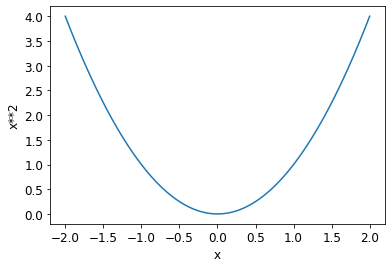

In [ ]:
plot_function(f, 'x', 'x**2')

The sequence of steps we described earlier starts by picking some random value for a parameter, and calculating the value of the loss:

我们前面描述的步骤顺序首先为参数选择一些随机值，并计算损失值:[机器翻译]

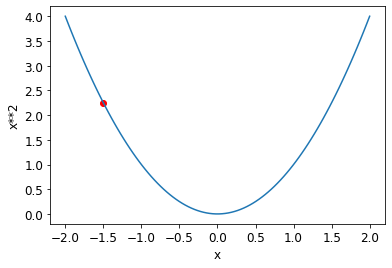

In [ ]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

Now we look to see what would happen if we increased or decreased our parameter by a little bit—the *adjustment*. This is simply the slope at a particular point:

现在我们看看如果我们增加或减少一点参数会发生什么-* 调整 *。这只是特定点的斜率:[机器翻译]

<img alt="A graph showing the squared function with the slope at one point" width="400" src="images/grad_illustration.svg"/>

<Img alt = "在某一点显示斜率的平方函数的图表" width = "400" src = "images/grad_illustration.svg"/>[机器翻译]

We can change our weight by a little in the direction of the slope, calculate our loss and adjustment again, and repeat this a few times. Eventually, we will get to the lowest point on our curve:

我们可以在斜坡的方向上稍微改变我们的重量，再次计算我们的损失和调整，并重复几次。最终，我们将到达曲线的最低点:[机器翻译]

<img alt="An illustration of gradient descent" width="400" src="images/chapter2_perfect.svg"/>

<Img alt = "渐变下降插图" width = "400" src = "images/chapter2_perfect.svg"/>[机器翻译]

This basic idea goes all the way back to Isaac Newton, who pointed out that we can optimize arbitrary functions in this way. Regardless of how complicated our functions become, this basic approach of gradient descent will not significantly change. The only minor changes we will see later in this book are some handy ways we can make it faster, by finding better steps.

这个基本的想法一直追溯到艾萨克·牛顿，他指出我们可以用这种方式优化任意函数。不管我们的函数变得多么复杂，这种梯度下降的基本方法不会发生显著变化。我们将在本书后面看到的唯一微小的变化是一些方便的方法，我们可以通过找到更好的步骤来使它更快。[机器翻译]

### Calculating Gradients

# 计算梯度[机器翻译]

The one magic step is the bit where we calculate the gradients. As we mentioned, we use calculus as a performance optimization; it allows us to more quickly calculate whether our loss will go up or down when we adjust our parameters up or down. In other words, the gradients will tell us how much we have to change each weight to make our model better.


一个神奇的步骤是我们计算梯度的位置。正如我们提到的，我们使用微积分作为性能优化; 它允许我们更快地计算当我们向上或向下调整参数时，我们的损失是上升还是下降。换句话说，梯度将告诉我们，为了使我们的模型更好，我们必须改变每个重量多少。[机器翻译]

You may remember from your high school calculus class that the *derivative* of a function tells you how much a change in its parameterss will change its result. If not, don't worry, lots of us forget calculus once high school is behind us! But you will have to have some intuitive understanding of what a derivative is before you continue, so if this is all very fuzzy in your head, head over to Khan Academy and complete the [lessons on basic derivatives](https://www.khanacademy.org/math/differential-calculus/dc-diff-intro). You won't have to know how to calculate them yourselves, you just have to know what a derivative is.


你可能还记得你的高中微积分课，函数的 * 导数 * 告诉你它的参数的变化会改变它的结果多少。如果没有，别担心，一旦高中毕业，我们很多人都会忘记微积分!但是在你继续之前，你必须对什么是导数有一些直观的理解，所以如果这在你的头脑中非常模糊，前往可汗学院并完成 [基本衍生工具课程] ( https://www.khanacademy.org/math/differential-calculus/dc-diff-intro )。你不必知道如何自己计算它们，你只需要知道什么是导数。[机器翻译]

The key point about a derivative is this: for any function, such as the quadratic function we saw in the previous section, we can calculate its derivative. The derivative is another function. It calculates the change, rather than the value. For instance, the derivative of the quadratic function at the value 3 tells us how rapidly the function changes at the value 3. More specifically, you may recall that gradient is defined as *rise/run*, that is, the change in the value of the function, divided by the change in the value of the parameter. When we know how our function will change, then we know what we need to do to make it smaller. This is the key to machine learning: having a way to change the parameters of a function to make it smaller. Calculus provides us with a computational shortcut, the derivative, which lets us directly calculate the gradients of our functions.

关于导数的关键点是这样的: 对于任何函数，例如我们在上一节中看到的二次函数，我们可以计算它的导数。导数是另一个函数。它计算更改，而不是值。例如，二次函数在值3处的导数告诉我们函数在值3处的变化有多快。更具体地说，您可能记得渐变被定义为 * 上升/运行 *，即函数值的变化除以参数值的变化。当我们知道我们的功能将如何改变时，我们就知道我们需要做什么来使它变小。这是机器学习的关键: 有一种方法来改变函数的参数，使它更小。微积分为我们提供了一个计算捷径，导数，它让我们可以直接计算函数的梯度。[机器翻译]

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative we won't get back one number, but lots of them—a gradient for every weight. But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.


需要注意的一件重要事情是，我们的函数有很多权重需要调整，所以当我们计算导数时，我们不会得到一个数字，但是很多-每个重量的梯度。但是在数学上没有什么棘手的; 您可以计算相对于一个权重的导数，并将所有其他权重视为常数，然后对彼此的权重重复此操作。这是计算每个权重的所有梯度的方式。[机器翻译]

We mentioned just now that you won't have to calculate any gradients yourself. How can that be? Amazingly enough, PyTorch is able to automatically compute the derivative of nearly any function! What's more, it does it very fast. Most of the time, it will be at least as fast as any derivative function that you can create by hand. Let's see an example.


我们刚才提到，你不必自己计算任何梯度。这是什么？令人惊讶的是，PyTorch能够自动计算几乎任何函数的导数!此外，它做得非常快。大多数时候，它至少和你可以手工创建的任何导数函数一样快。让我们看一个例子。[机器翻译]

First, let's pick a tensor value which we want gradients at:

首先，让我们选择一个我们想要渐变的张量值:[机器翻译]

In [ ]:
xt = tensor(3.).requires_grad_()

Notice the special method `requires_grad_`? That's the magical incantation we use to tell PyTorch that we want to calculate gradients with respect to that variable at that value. It is essentially tagging the variable, so PyTorch will remember to keep track of how to compute gradients of the other, direct calculations on it that you will ask for.


注意特殊方法 'requires_grad _'？这是我们用来告诉PyTorch的神奇咒语，我们希望在该值计算相对于该变量的梯度。它本质上是在标记变量，所以PyTorch会记住如何计算另一个变量的梯度，直接计算你会要求的。[机器翻译]

> a: This API might throw you off if you're coming from math or physics. In those contexts the "gradient" of a function is just another function (i.e., its derivative), so you might expect gradient-related APIs to give you a new function. But in deep learning, "gradients" usually means the _value_ of a function's derivative at a particular argument value. The PyTorch API also puts the focus on the argument, not the function you're actually computing the gradients of. It may feel backwards at first, but it's just a different perspective.


> 答: 如果你来自数学或物理，这个API可能会让你失望。在这些上下文中，函数的 “梯度” 只是另一个函数 (即它的导数)，所以你可能期望梯度相关的api给你一个新的函数。但是在深度学习中，“梯度” 通常意味着函数在特定参数值的导数的 _ value _。PyTorch API还将焦点放在参数上，而不是您实际计算梯度的函数。起初可能会感觉倒退，但这只是一个不同的视角。[机器翻译]

Now we calculate our function with that value. Notice how PyTorch prints not just the value calculated, but also a note that it has a gradient function it'll be using to calculate our gradients when needed:

现在我们用该值计算我们的函数。请注意PyTorch打印的不仅仅是计算的值，还需要注意的是，它有一个梯度函数，在需要时可以用来计算我们的梯度:[机器翻译]

In [ ]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

Finally, we tell PyTorch to calculate the gradients for us:

最后，我们告诉PyTorch为我们计算梯度:[机器翻译]

In [ ]:
yt.backward()

The "backward" here refers to *backpropagation*, which is the name given to the process of calculating the derivative of each layer. We'll see how this is done exactly in chapter <<chapter_foundations>>, when we calculate the gradients of a deep neural net from scratch. This is called the "backward pass" of the network, as opposed to the "forward pass," which is where the activations are calculated. Life would probably be easier if `backward` was just called `calculate_grad`, but deep learning folks really do like to add jargon everywhere they can!

这里的 “向后” 是指 * 反向传播 *，它是计算每层导数的过程的名称。当我们从头开始计算深度神经网络的梯度时，我们将在第 <chapter_foundations>> 章中看到这是如何完成的。这被称为网络的 “反向通过”，而不是计算激活的 “正向通过”。如果 “backward” 被称为 “calculate_grad”，生活可能会更容易，但是深度学习的人确实喜欢在任何地方添加行话![机器翻译]

We can now view the gradients by checking the `grad` attribute of our tensor:

我们现在可以通过检查张量的 “渐变” 属性来查看渐变:[机器翻译]

In [ ]:
xt.grad

tensor(6.)

If you remember your high school calculus rules, the derivative of `x**2` is `2*x`, and we have `x=3`, so the gradients should be `2*3=6`, which is what PyTorch calculated for us!


如果你记得你的高中微积分规则，'x * * 2' 的导数是 '2 * x'，我们有 'x = 3'，所以梯度应该是 '2*3 = 6'，这是PyTorch为我们计算的![机器翻译]

Now we'll repeat the preceding steps, but with a vector argument for our function:

现在我们将重复前面的步骤，但是使用函数的向量参数:[机器翻译]

In [ ]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

And we'll add `sum` to our function so it can take a vector (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor):

我们将把 “sum” 添加到我们的函数中，这样它就可以取一个向量 (i e.，rank-1张量)，并返回一个标量 (i.e.，一个秩-0张量):[机器翻译]

In [ ]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Our gradients are `2*xt`, as we'd expect!

正如我们所料，我们的梯度是 '2 * x'![机器翻译]

In [ ]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

The gradients only tell us the slope of our function, they don't actually tell us exactly how far to adjust the parameters. But it gives us some idea of how far; if the slope is very large, then that may suggest that we have more adjustments to do, whereas if the slope is very small, that may suggest that we are close to the optimal value.

梯度只告诉我们函数的斜率，实际上并没有告诉我们调整参数的确切距离。但是它给了我们一些关于多远的想法; 如果坡度很大，那么这可能意味着我们有更多的调整要做，而如果坡度很小，这可能表明我们接近最佳值。[机器翻译]

### Stepping With a Learning Rate

# 以学习速度步进[机器翻译]

Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the *learning rate* (LR). The learning rate is often a number between 0.001 and 0.1, although it could be anything. Often, people select a learning rate just by trying a few, and finding which results in the best model after training (we'll show you a better approach later in this book, called the *learning rate finder*). Once you've picked a learning rate, you can adjust your parameters using this simple function:


决定如何根据梯度值改变我们的参数是深度学习过程的一个重要部分。几乎所有的方法都是从梯度乘以一些小数字的基本思想开始的，称为 * 学习率 * (LR)。学习率通常是一个介于0.001和0.1之间的数字，尽管它可能是任何东西。通常，人们只通过尝试几个来选择学习率，并在训练后找到最佳模型 (我们将在本书后面向您展示一种更好的方法，称为 * 学习速率查找器 *)。选择学习速率后，您可以使用以下简单函数调整参数:[机器翻译]

```
w -= gradient(w) * lr
```


'''
W-= 梯度 (w) * lr
'''[机器翻译]

This is known as *stepping* your parameters, using an *optimizer step*.


这被称为 * 步进 * 您的参数，使用 * 优化器步骤 *。[机器翻译]

If you pick a learning rate that's too low, it can mean having to do a lot of steps. <<descent_small>> illustrates that.

如果你选择的学习率太低，这可能意味着必须做很多步骤。<<Descent_small>> 说明了这一点。[机器翻译]

<img alt="An illustration of gradient descent with a LR too low" width="400" caption="Gradient descent with low LR" src="images/chapter2_small.svg" id="descent_small"/>

<Img alt = "LR太低的渐变下降插图" width = "400" caption = "低LR的渐变下降" src = "images/chapter2_small.svg" id = "descent_small"/>[机器翻译]

But picking a learning rate that's too high is even worse—it can actually result in the loss getting *worse*, as we see in <<descent_div>>!

但是选择一个太高的学习率甚至更糟-它实际上会导致损失变得更糟 *，正如我们在 <<descent_div>> 中看到的那样![机器翻译]

<img alt="An illustration of gradient descent with a LR too high" width="400" caption="Gradient descent with high LR" src="images/chapter2_div.svg" id="descent_div"/>

<Img alt = "LR太高的渐变下降插图" width = "400" caption = "高LR的渐变下降" src = "images/chapter2_div.svg" id = "descent_div"/>[机器翻译]

If the learning rate is too high, it may also "bounce" around, rather than actually diverging; <<descent_bouncy>> shows how this has the result of taking many steps to train successfully.

如果学习率太高，它也可能 “反弹”，而不是实际上发散; <<descent_bouncy>> 展示了采取许多步骤成功训练的结果。[机器翻译]

<img alt="An illustation of gradient descent with a bouncy LR" width="400" caption="Gradient descent with bouncy LR" src="images/chapter2_bouncy.svg" id="descent_bouncy"/>

<Img alt = "具有弹性LR的梯度下降插图" width = "400" caption = "具有弹性LR的梯度下降" src = "images/chapter2_bouncy.svg" id = "descent_bouncy"/>[机器翻译]

Now let's apply all of this in an end-to-end example.

现在让我们在一个端到端示例中应用所有这些。[机器翻译]

### An End-to-End SGD Example

# 端到端SGD示例[机器翻译]

We've seen how to use gradients to find a minimum. Now it's time to look at an SGD example and see how finding a minimum can be used to train a model to fit data better.


我们已经看到如何使用渐变来找到最小值。现在是时候看看SGD的例子，看看如何利用找到最小值来训练模型以更好地适应数据。[机器翻译]

Let's start with a simple, synthetic, example model. Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:

让我们从一个简单的，合成的，示例模型开始。想象一下，当过山车越过驼峰时，你正在测量它的速度。它会开始得很快，然后在上山时变得更慢; 它在顶部最慢，然后在下坡时再次加速。你想建立一个速度如何随时间变化的模型。如果你每秒钟手动测量速度20秒，它可能看起来像这样:[机器翻译]

In [ ]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

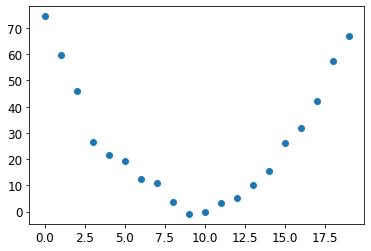

In [ ]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

We've added a bit of random noise, since measuring things manually isn't precise. This means it's not that easy to answer the question: what was the roller coaster's speed? Using SGD we can try to find a function that matches our observations. We can't consider every possible function, so let's use a guess that it will be quadratic; i.e., a function of the form `a*(time**2)+(b*time)+c`.


我们增加了一点随机噪音，因为手动测量东西并不精确。这意味着回答这个问题并不容易: 过山车的速度是多少？使用SGD，我们可以尝试找到一个与我们的观察结果相匹配的函数。我们不能考虑每一个可能的函数，所以让我们用一个猜测，它将是二次的; 即，形式为a '* (时间 * * 2) (b * 时间) 的函数C'。[机器翻译]

We want to distinguish clearly between the function's input (the time when we are measuring the coaster's speed) and its parameters (the values that define *which* quadratic we're trying). So, let's collect the parameters in one argument and thus separate the input, `t`, and the parameters, `params`, in the function's signature: 

我们想清楚地区分函数的输入 (我们测量过山车速度的时间) 和它的参数 (定义 * 我们正在尝试的二次方的值)。因此，让我们在一个参数中收集参数，从而将函数签名中的输入 “t” 和参数 “参数” 分开:[机器翻译]

In [ ]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In other words, we've restricted the problem of finding the best imaginable function that fits the data, to finding the best *quadratic* function. This greatly simplifies the problem, since every quadratic function is fully defined by the three parameters `a`, `b`, and `c`. Thus, to find the best quadratic function, we only need to find the best values for `a`, `b`, and `c`.


换句话说，我们将找到适合数据的最佳可想象函数的问题限制在找到最佳 * 二次 * 函数。这大大简化了问题，因为每个二次函数都完全由三个参数 'a' 、 'b' 和 'c' 定义。因此，为了找到最佳二次函数，我们只需要找到 “a” 、 “b” 和 “c” 的最佳值。[机器翻译]

If we can solve this problem for the three parameters of a quadratic function, we'll be able to apply the same approach for other, more complex functions with more parameters—such as a neural net. Let's find the parameters for `f` first, and then we'll come back and do the same thing for the MNIST dataset with a neural net.


如果我们能为二次函数的三个参数解决这个问题，我们就能为其他更复杂的、参数更多的函数应用同样的方法 -- 比如神经网络。让我们先找到 “f” 的参数，然后再回来，用神经网络对MNIST数据集做同样的事情。[机器翻译]

We need to define first what we mean by "best." We define this precisely by choosing a *loss function*, which will return a value based on a prediction and a target, where lower values of the function correspond to "better" predictions. For continuous data, it's common to use *mean squared error*:

我们需要首先定义我们所说的 “最好” 是什么意思我们通过选择一个 * 损失函数 * 来精确定义这一点，它将返回一个基于预测和目标的值，其中函数的较低值对应于 “更好” 的预测。对于连续数据，通常使用 * 均方误差 *:[机器翻译]

In [ ]:
def mse(preds, targets): return ((preds-targets)**2).mean()

Now, let's work through our 7 step process.

现在，让我们完成我们的7步流程。[机器翻译]

#### Step 1: Initialize the parameters

# 步骤1: 初始化参数[机器翻译]

First, we initialize the parameters to random values, and tell PyTorch that we want to track their gradients, using `requires_grad_`:

首先，我们将参数初始化为随机值，并告诉PyTorch我们想要跟踪它们的梯度，使用 'requires_grad _':[机器翻译]

In [ ]:
params = torch.randn(3).requires_grad_()

In [ ]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

# 步骤2: 计算预测[机器翻译]

Next, we calculate the predictions:

接下来，我们计算预测:[机器翻译]

In [ ]:
preds = f(time, params)

Let's create a little function to see how close our predictions are to our targets, and take a look:

让我们创建一个小函数来看看我们的预测与目标有多接近，并看一看:[机器翻译]

In [ ]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

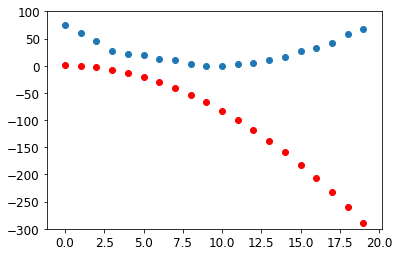

In [ ]:
show_preds(preds)

This doesn't look very close—our random parameters suggest that the roller coaster will end up going backwards, since we have negative speeds!

这看起来不是很接近-我们的随机参数表明过山车最终会倒退，因为我们有负速度![机器翻译]

#### Step 3: Calculate the loss

# 步骤3: 计算损失[机器翻译]

We calculate the loss as follows:

我们计算损失如下:[机器翻译]

In [ ]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

Our goal is now to improve this. To do that, we'll need to know the gradients.

我们现在的目标是改善这一点。要做到这一点，我们需要知道梯度。[机器翻译]

#### Step 4: Calculate the gradients

# 步骤4: 计算梯度[机器翻译]

The next step is to calculate the gradients. In other words, calculate an approximation of how the parameters need to change:

下一步是计算梯度。换句话说，计算参数需要如何更改的近似值:[机器翻译]

In [ ]:
loss.backward()
params.grad

tensor([-53195.8594,  -3419.7146,   -253.8908])

In [ ]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

We can use these gradients to improve our parameters. We'll need to pick a learning rate (we'll discuss how to do that in practice in the next chapter; for now we'll just use 1e-5, or 0.00001):

我们可以使用这些梯度来改进我们的参数。我们需要选择一个学习率 (我们将在下一章讨论如何在实践中做到这一点; 现在我们只使用1e-5或0.00001):[机器翻译]

In [ ]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

#### Step 5: Step the weights. 

# 第5步: 步重。[机器翻译]

Now we need to update the parameters based on the gradients we just calculated:

现在我们需要根据刚刚计算的梯度更新参数:[机器翻译]

In [ ]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

> a: Understanding this bit depends on remembering recent history. To calculate the gradients we call `backward` on the `loss`. But this `loss` was itself calculated by `mse`, which in turn took `preds` as an input, which was calculated using `f` taking as an input `params`, which was the object on which we originally called `required_grads_`—which is the original call that now allows us to call `backward` on `loss`. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.

> 答: 了解这一点取决于记住最近的历史。为了计算梯度，我们称之为 “损失” 上的 “反向”。但是这个 '损失' 本身是由 'mse' 计算的，它反过来将 'preds' 作为输入，使用 'f' 作为输入 '参数' 计算，这是我们最初调用 'required_grads _' 的对象-这是现在允许我们在 'loss' 上调用 'backward' 的原始调用。这个函数调用链代表了函数的数学组成，这使得PyTorch能够使用引擎盖下的微积分链规则来计算这些梯度。[机器翻译]

Let's see if the loss has improved:

让我们看看损失是否有所改善:[机器翻译]

In [ ]:
preds = f(time,params)
mse(preds, speed)

tensor(5435.5366, grad_fn=<MeanBackward0>)

And take a look at the plot:

看看这个情节:[机器翻译]

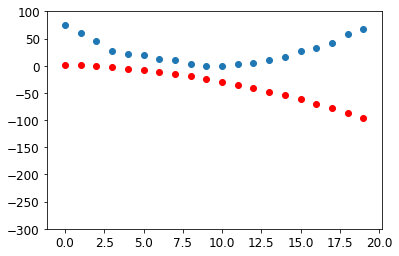

In [ ]:
show_preds(preds)

We need to repeat this a few times, so we'll create a function to apply one step:

我们需要重复几次，所以我们将创建一个函数来应用一步:[机器翻译]

In [ ]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

# 步骤6: 重复这个过程[机器翻译]

Now we iterate. By looping and performing many improvements, we hope to reach a good result:

现在我们迭代。通过循环和执行许多改进，我们希望达到一个好的结果:[机器翻译]

In [ ]:
for i in range(10): apply_step(params)

5435.53662109375
1577.4495849609375
847.3780517578125
709.22265625
683.0757446289062
678.12451171875
677.1839599609375
677.0025024414062
676.96435546875
676.9537353515625


In [ ]:
#hide
params = orig_params.detach().requires_grad_()

The loss is going down, just as we hoped! But looking only at these loss numbers disguises the fact that each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. We can see this process visually if, instead of printing out the loss function, we plot the function at every step. Then we can see how the shape is approaching the best possible quadratic function for our data:

损失正在下降，正如我们所希望的那样!但是只看这些损失数字掩盖了这样一个事实，即每次迭代都代表了一个完全不同的二次函数，在寻找最好的二次函数的路上。如果我们不是打印出损失函数，而是在每一步绘制函数，我们可以直观地看到这个过程。然后我们可以看到形状如何接近我们数据的最佳二次函数:[机器翻译]

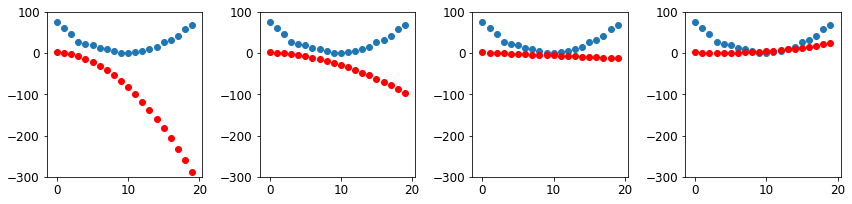

In [ ]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

# 步骤7: 停止[机器翻译]

We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop, as we've discussed.

我们只是决定在10次之后任意停止。实际上，我们会观察培训和验证损失以及我们的指标，以决定何时停止，正如我们已经讨论过的那样。[机器翻译]

### Summarizing Gradient Descent

# 总结梯度下降[机器翻译]

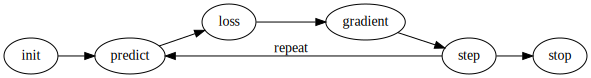

In [ ]:
#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

To summarize, at the beginning, the weights of our model can be random (training *from scratch*) or come from a pretrained model (*transfer learning*). In the first case, the output we will get from our inputs won't have anything to do with what we want, and even in the second case, it's very likely the pretrained model won't be very good at the specific task we are targeting. So the model will need to *learn* better weights.


总而言之，在开始时，我们模型的权重可以是随机的 (训练 * 从头开始 *)，也可以来自预先训练的模型 (* 迁移学习 *)。在第一种情况下，我们将从输入中获得的输出与我们想要的没有任何关系，即使在第二种情况下，很有可能预先训练的模型不太擅长我们的目标任务。因此，模型需要 * 学习 * 更好的权重。[机器翻译]

We begin by comparing the outputs the model gives us with our targets (we have labeled data, so we know what result the model should give) using a *loss function*, which returns a number that we want to make as low as possible by improving our weights. To do this, we take a few data items (such as images) from the training set and feed them to our model. We compare the corresponding targets using our loss function, and the score we get tells us how wrong our predictions were. We then change the weights a little bit to make it slightly better.


我们首先使用 * 损失函数 * 比较模型给我们的输出和我们的目标 (我们有标记数据，所以我们知道模型应该给出什么结果)，它返回一个我们希望通过提高重量来尽可能低的数字。为此，我们从训练集中获取一些数据项 (如图像)，并将它们馈送到我们的模型中。我们使用我们的损失函数比较相应的目标，我们得到的分数告诉我们我们的预测有多错误。然后我们稍微改变一下重量，使它稍微好一点。[机器翻译]

To find how to change the weights to make the loss a bit better, we use calculus to calculate the *gradients*. (Actually, we let PyTorch do it for us!) Let's consider an analogy. Imagine you are lost in the mountains with your car parked at the lowest point. To find your way back to it, you might wander in a random direction, but that probably wouldn't help much. Since you know your vehicle is at the lowest point, you would be better off going downhill. By always taking a step in the direction of the steepest downward slope, you should eventually arrive at your destination. We use the magnitude of the gradient (i.e., the steepness of the slope) to tell us how big a step to take; specifically, we multiply the gradient by a number we choose called the *learning rate* to decide on the step size. We then *iterate* until we have reached the lowest point, which will be our parking lot, then we can *stop*.


为了找到如何改变权重以使损失更好，我们使用微积分来计算 * 梯度 *。(实际上，我们让PyTorch为我们做这件事!) 让我们考虑一个类比。想象一下，你在山里迷路了，你的车停在最低点。为了找到回到它的路，你可能会在一个随机的方向上徘徊，但这可能不会有多大帮助。既然你知道你的车在最低点，你最好下坡。总是朝着最陡的下坡方向迈出一步，你最终应该到达目的地。我们使用梯度的大小 (i.e.，坡度) 来告诉我们要走多大的一步; 具体来说，我们将梯度乘以一个我们选择的数字，称为 * 学习率 * 来决定步长。然后我们 * 迭代 * 直到我们到达最低点，这将是我们的停车场，然后我们可以 * 停止 *。[机器翻译]

All of that we just saw can be transposed directly to the MNIST dataset, except for the loss function. Let's now see how we can define a good training objective. 

除了损失函数之外，我们刚刚看到的所有内容都可以直接转置到MNIST数据集。现在让我们看看如何定义一个好的培训目标。[机器翻译]

## The MNIST Loss Function

# # MNIST损失函数[机器翻译]

We already have our dependent variables `x`—these are the images themselves. We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). We can do this using `view`, which is a PyTorch method that changes the shape of a tensor without changing its contents. `-1` is a special parameter to `view` that means "make this axis as big as necessary to fit all the data":

我们已经有了我们的因变量 “x”-这些是图像本身。我们将把它们全部连接成一个张量，并将它们从矩阵列表 (秩-3张量) 更改为向量列表 (秩-2张量)。我们可以使用 “view” 来实现这一点，这是一种PyTorch方法，它可以在不改变张量内容的情况下改变张量的形状。'-1' 是 'view' 的一个特殊参数，意思是 “使这个轴尽可能大，以适应所有数据”:[机器翻译]

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

We need a label for each image. We'll use `1` for 3s and `0` for 7s:

我们需要每个图像的标签。我们将 “1” 用于3s，“0” 用于7s:[机器翻译]

In [ ]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

索引时需要PyTorch中的 'dataset' 才能返回 '(x，y)' 的元组。Python提供了一个 “zip” 函数，当与 “list” 结合时，它提供了一种获得此功能的简单方法:[机器翻译]

In [ ]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need an (initially random) weight for every pixel (this is the *initialize* step in our seven-step process):

现在我们需要每个像素的 (最初随机) 权重 (这是我们七步过程中的 * initialize * 步骤):[机器翻译]

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

The function `weights*pixels` won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its *intercept* is 0). You might remember from high school math that the formula for a line is `y=w*x+b`; we still need the `b`. We'll initialize it to a random number too:

函数 “权重 * 像素” 不够灵活 -- 当像素等于0时，它总是等于0 (即，它的 * 截距 * 是0)。你可能还记得高中数学的公式是 'y = w * x b'; 我们仍然需要 'b'。我们也将它初始化为一个随机数:[机器翻译]

In [ ]:
bias = init_params(1)

In neural networks, the `w` in the equation `y=w*x+b` is called the *weights*, and the `b` is called the *bias*. Together, the weights and bias make up the *parameters*.

在神经网络中，方程 'y = w * x b' 中的 'w' 称为 * 权重 *，'b' 称为 * 偏差 *。权重和偏差一起构成 * 参数 *。[机器翻译]

> jargon: Parameters: The _weights_ and _biases_ of a model. The weights are the `w` in the equation `w*x+b`, and the biases are the `b` in that equation.

> 行话: 参数: 模型的 _ 权重 _ 和 _ 偏差 _。权重是等式 “w * x b” 中的 “w”，偏差是该等式中的 “b”。[机器翻译]

We can now calculate a prediction for one image:

我们现在可以计算一个图像的预测:[机器翻译]

In [ ]:
(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

While we could use a Python `for` loop to calculate the prediction for each image, that would be very slow. Because Python loops don't run on the GPU, and because Python is a slow language for loops in general, we need to represent as much of the computation in a model as possible using higher-level functions.


虽然我们可以使用Python “for” 循环来计算每个图像的预测，但这将非常慢。因为Python循环不会在GPU上运行，而且因为Python通常是一种缓慢的循环语言，所以我们需要使用更高级的函数在模型中尽可能多地表示计算。[机器翻译]

In this case, there's an extremely convenient mathematical operation that calculates `w*x` for every row of a matrix—it's called *matrix multiplication*. <<matmul>> shows what matrix multiplication looks like.

在这种情况下，有一个非常方便的数学运算，为矩阵的每一行计算 “w * x”-它被称为 * 矩阵乘法 *。<<Matmul>> 显示了矩阵乘法的外观。[机器翻译]

<img alt="Matrix multiplication" width="400" caption="Matrix multiplication" src="images/matmul2.svg" id="matmul"/>

<Img alt = "矩阵乘法" width = "400" caption = "矩阵乘法" src = "images/matmul2.svg" id = "matmul"/>[机器翻译]

This image shows two matrices, `A` and `B`, being multiplied together. Each item of the result, which we'll call `AB`, contains each item of its corresponding row of `A` multiplied by each item of its corresponding column of `B`, added together. For instance, row 1, column 2 (the orange dot with a red border) is calculated as $a_{1,1} * b_{1,2} + a_{1,2} * b_{2,2}$. If you need a refresher on matrix multiplication, we suggest you take a look at the [Intro to Matrix Multiplication](https://youtu.be/kT4Mp9EdVqs) on *Khan Academy*, since this is the most important mathematical operation in deep learning.


此图像显示两个矩阵，“a” 和 “b”，相乘在一起。结果的每个项目，我们称之为 “ab”，包含其相应行 “a” 的每个项目乘以其相应列 “b” 的每个项目，并加在一起。例如，第1行第2列 (带有红色边框的橙色点) 计算为 $ a _{1,1} * b _{1,2} a _{1,2} * b _{2,2}$。如果你需要复习一下矩阵乘法，我们建议你看看 [矩阵乘法入门] ( https://youtu.be/kT4Mp9EdVqs ) On * Khan Academy *，因为这是深度学习中最重要的数学运算。[机器翻译]

In Python, matrix multiplication is represented with the `@` operator. Let's try it:

在Python中，矩阵乘法用 “@” 运算符表示。让我们试试:[机器翻译]

In [ ]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

The first element is the same as we calculated before, as we'd expect. This equation, `batch@weights + bias`, is one of the two fundamental equations of any neural network (the other one is the *activation function*, which we'll see in a moment).

第一个元素与我们之前计算的相同，正如我们所期望的。这个方程，“批量 @ 权重偏差”，是任何神经网络的两个基本方程之一 (另一个是 * 激活函数 *，我们稍后会看到)。[机器翻译]

Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0, so our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

让我们检查一下我们的准确性。要决定输出代表3还是7，我们可以检查它是否大于0，这样我们就可以计算每个项目的准确性 (使用广播，所以没有循环!) 带:[机器翻译]

In [ ]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [ ]:
corrects.float().mean().item()

0.4912068545818329

Now let's see what the change in accuracy is for a small change in one of the weights:

现在让我们看看其中一个权重的微小变化在准确性上的变化是什么:[机器翻译]

In [ ]:
weights[0] *= 1.0001

In [ ]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4912068545818329

As we've seen, we need gradients in order to improve our model using SGD, and in order to calculate gradients we need some *loss function* that represents how good our model is. That is because the gradients are a measure of how that loss function changes with small tweaks to the weights.


正如我们所看到的，我们需要梯度来改进我们使用SGD的模型，为了计算梯度，我们需要一些 * 损失函数 * 来表示我们的模型有多好。这是因为梯度是通过对权重的小调整来衡量损失函数如何变化的度量。[机器翻译]

So, we need to choose a loss function. The obvious approach would be to use accuracy, which is our metric, as our loss function as well. In this case, we would calculate our prediction for each image, collect these values to calculate an overall accuracy, and then calculate the gradients of each weight with respect to that overall accuracy.


所以，我们需要选择一个损失函数。显而易见的方法是使用准确性，这是我们的度量，也是我们的损失函数。在这种情况下，我们将计算每个图像的预测，收集这些值以计算整体精度，然后计算每个权重相对于整体精度的梯度。[机器翻译]

Unfortunately, we have a significant technical problem here. The gradient of a function is its *slope*, or its steepness, which can be defined as *rise over run*—that is, how much the value of the function goes up or down, divided by how much we changed the input. We can write this in mathematically as: `(y_new - y_old) / (x_new - x_old)`. This gives us a good approximation of the gradient when `x_new` is very similar to `x_old`, meaning that their difference is very small. But accuracy only changes at all when a prediction changes from a 3 to a 7, or vice versa. The problem is that a small change in weights from `x_old` to `x_new` isn't likely to cause any prediction to change, so `(y_new - y_old)` will almost always be 0. In other words, the gradient is 0 almost everywhere.

不幸的是，我们这里有一个重大的技术问题。函数的梯度是它的 * 斜率 *，或者它的陡度，可以定义为 * 上升超过运行 *-即，函数的值上升或下降了多少，除以我们改变了多少输入。我们可以用数学形式写这个: '(y_new - y_old) / (x_new-x_old)'。当 “x_new” 与 “x_old” 非常相似时，这给了我们一个很好的梯度近似值，这意味着它们的差异非常小。但是，只有当预测从3变为7时，准确性才会发生变化，反之亦然。问题是权重从 “x_old” 到 “x_new” 的微小变化不太可能导致任何预测发生变化，所以 “(y _ new - y _ old)'几乎总是0。换句话说，梯度几乎到处都是0。[机器翻译]

A very small change in the value of a weight will often not actually change the accuracy at all. This means it is not useful to use accuracy as a loss function—if we do, most of the time our gradients will actually be 0, and the model will not be able to learn from that number.


权重值的非常小的变化通常根本不会改变精度。这意味着使用精度作为损失函数是没有用的 -- 如果我们这样做了，大多数时候我们的梯度实际上是0，模型将无法从这个数字中学习。[机器翻译]

> S: In mathematical terms, accuracy is a function that is constant almost everywhere (except at the threshold, 0.5), so its derivative is nil almost everywhere (and infinity at the threshold). This then gives gradients that are 0 or infinite, which are useless for updating the model.


> S: 在数学术语中，精度是一个几乎在任何地方都是常数的函数 (除了在阈值，0.5)，因此它的导数几乎在任何地方都是nil (并且在阈值处是无穷大)。然后给出0或无限的梯度，这对于更新模型是无用的。[机器翻译]

Instead, we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. So what does a "slightly better prediction" look like, exactly? Well, in this case, it means that if the correct answer is a 3 the score is a little higher, or if the correct answer is a 7 the score is a little lower.


相反，我们需要一个损失函数，当我们的权重导致稍微好一点的预测时，它会给我们带来稍微好一点的损失。那么，“稍微好一点的预测” 到底是什么样子的呢？嗯，在这种情况下，这意味着如果正确答案是a 3，分数会高一点，或者如果正确答案是a 7，分数会低一点。[机器翻译]

Let's write such a function now. What form does it take?


现在让我们写这样一个函数。它采取什么形式？[机器翻译]

The loss function receives not the images themseles, but the predictions from the model. Let's make one argument, `prds`, of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., a rank-1 tensor), indexed over the images.


损失函数接收的不是自己选择的图像，而是来自模型的预测。让我们做一个参数，“prds”，值介于0和1之间，其中每个值是图像是3的预测。它是一个向量 (i.e.，秩-1张量)，在图像上索引。[机器翻译]

The purpose of the loss function is to measure the difference between predicted values and the true values — that is, the targets (aka labels). Let's make another argument, `trgts`, with values of 0 or 1 which tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.


损失函数的目的是测量预测值和真值之间的差异-即目标 (又名标签)。让我们做另一个参数，'trgts'，值为0或1，它告诉图像实际上是否为3。它也是一个向量 (即另一个秩1张量)，在图像上索引。[机器翻译]

So, for instance, suppose we had three images which we knew were a 3, a 7, and a 3. And suppose our model predicted with high confidence (`0.9`) that the first was a 3, with slight confidence (`0.4`) that the second was a 7, and with fair confidence (`0.2`), but incorrectly, that the last was a 7. This would mean our loss function would receive these values as its inputs:

例如，假设我们有三个我们知道的图像是3、7和3。假设我们的模型高置信度 ('0.9') 预测第一个是3，轻微的置信度 ('0.4') 第二个是7，并且具有公平的置信度('0.2')，但不正确的是，最后一个是7。这意味着我们的损失函数将接收这些值作为其输入:[机器翻译]

In [ ]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

Here's a first try at a loss function that measures the distance between `predictions` and `targets`:

这是第一次尝试一个损失函数来测量 “预测” 和 “目标” 之间的距离:[机器翻译]

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

We're using a new function, `torch.where(a,b,c)`. This is the same as running the list comprehension `[b[i] if a[i] else c[i] for i in range(len(a))]`, except it works on tensors, at C/CUDA speed. In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.


我们正在使用一个新的函数，'torch.where(a，b，c)'。这与运行列表理解 '[b[i] if a[i] else c[i] for i in range(len(a))]'，除了它在张量上工作，在C/CUDA速度。在简单的英语中，这个函数将测量如果它应该是1，那么每个预测离1有多远，如果它应该是0，那么它离0有多远，然后它将采取所有这些距离的平均值。[机器翻译]

> note: Read the Docs: It's important to learn about PyTorch functions like this, because looping over tensors in Python performs at Python speed, not C/CUDA speed! Try running `help(torch.where)` now to read the docs for this function, or, better still, look it up on the PyTorch documentation site.

> 注意: 阅读文档: 了解这样的PyTorch函数很重要，因为在Python中循环tensor以Python速度执行，而不是C/CUDA速度!现在尝试运行 “help(torch.where)” 来阅读此功能的文档，或者更好的是，在PyTorch文档网站上查找它。[机器翻译]

Let's try it on our `prds` and `trgts`:

让我们在我们的 “prds” 和 “trgt” 上试试:[机器翻译]

In [ ]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

You can see that this function returns a lower number when predictions are more accurate, when accurate predictions are more confident (higher absolute values), and when inaccurate predictions are less confident. In PyTorch, we always assume that a lower value of a loss function is better. Since we need a scalar for the final loss, `mnist_loss` takes the mean of the previous tensor:

您可以看到，当预测更准确、准确预测更有信心 (绝对值更高) 以及不准确预测更不自信时，此函数返回较低的数字。在PyTorch中，我们总是假设损失函数的值越低越好。因为我们需要一个标量来表示最终损失，所以 'mnist_loss' 取上一个张量的平均值:[机器翻译]

In [ ]:
mnist_loss(prds,trgts)

tensor(0.4333)

For instance, if we change our prediction for the one "false" target from `0.2` to `0.8` the loss will go down, indicating that this is a better prediction:

例如，如果我们将对一个 “错误” 目标的预测从 “0.2” 更改为 “0.8”，损失将会下降，这表明这是一个更好的预测:[机器翻译]

In [ ]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

One problem with `mnist_loss` as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that—let's take a look.

当前定义的 “mnist_loss” 的一个问题是，它假设预测总是在0和1之间。那么，我们需要确保事实就是如此!碰巧的是，有一个函数可以做到这一点 -- 让我们来看看。[机器翻译]

### Sigmoid

### 乙状[机器翻译]

The `sigmoid` function always outputs a number between 0 and 1. It's defined as follows:

“Sigmoid” 函数始终输出一个介于0和1之间的数字。定义如下:[机器翻译]

In [ ]:
def sigmoid(x): return 1/(1+torch.exp(-x))

Pytorch defines an accelerated version for us, so we don’t really need our own. This is an important function in deep learning, since we often want to ensure values are between 0 and 1. This is what it looks like:

Pytorch为我们定义了一个加速版本，所以我们不需要自己的版本。这是深度学习中的一个重要功能，因为我们经常希望确保值介于0和1之间。这就是它的样子:[机器翻译]

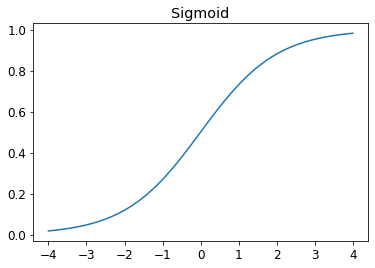

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

As you can see, it takes any input value, positive or negative, and smooshes it onto an output value between 0 and 1. It's also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients. 


正如你所看到的，它接受任何输入值，正的或负的，并将其平滑到0和1之间的输出值。它也是一条只向上的平滑曲线，这使得SGD更容易找到有意义的梯度。[机器翻译]

Let's update `mnist_loss` to first apply `sigmoid` to the inputs:

让我们更新 “mnist_loss” 以首先将 “sigmoid” 应用于输入:[机器翻译]

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Now we can be confident our loss function will work, even if the predictions are not between 0 and 1. All that is required is that a higher prediction corresponds to higher confidence an image is a 3.


现在我们可以确信我们的损失函数会起作用，即使预测不在0和1之间。所有需要的是，更高的预测对应于更高的置信度图像是3。[机器翻译]

Having defined a loss function, now is a good moment to recapitulate why we did this. After all, we already had a metric, which was overall accuracy. So why did we define a loss?


定义了损失函数后，现在是概括我们为什么这样做的好时机。毕竟，我们已经有了一个指标，即整体准确性。那么我们为什么要给损失下定义呢？[机器翻译]

The key difference is that the metric is to drive human understanding and the loss is to drive automated learning. To drive automated learning, the loss must be a function that has a meaningful derivative. It can't have big flat sections and large jumps, but instead must be reasonably smooth. This is why we designed a loss function that would respond to small changes in confidence level. This requirement means that sometimes it does not really reflect exactly what we are trying to achieve, but is rather a compromise between our real goal, and a function that can be optimized using its gradient. The loss function is calculated for each item in our dataset, and then at the end of an epoch the loss values are all averaged and the overall mean is reported for the epoch.


关键的区别在于，度量标准是驱动人类的理解，而损失是驱动自动化学习。为了驱动自动化学习，损失必须是一个具有有意义导数的函数。它不能有大的平坦部分和大的跳跃，而是必须相当平滑。这就是为什么我们设计了一个损失函数来响应置信水平的小变化。这个要求意味着有时它并没有真正反映出我们试图实现的目标，而是我们真正的目标和一个可以使用梯度进行优化的函数之间的妥协。为我们的数据集中的每个项目计算损失函数，然后在历代结束时，损失值全部被平均，并为历代报告总体平均值。[机器翻译]

Metrics, on the other hand, are the numbers that we really care about. These are the values that are printed at the end of each epoch that tell us how our model is really doing. It is important that we learn to focus on these metrics, rather than the loss, when judging the performance of a model.

另一方面，指标是我们真正关心的数字。这些是在每个时代结束时打印的值，告诉我们我们的模型实际上是如何运行的。重要的是，在判断模型的性能时，我们要学会关注这些指标，而不是损失。[机器翻译]

### SGD and Mini-Batches

# # SGD和迷你批次[机器翻译]

Now that we have a loss function that is suitable for driving SGD, we can consider some of the details involved in the next phase of the learning process, which is to change or update the weights based on the gradients. This is called an *optimization step*.


现在我们有了一个适合驱动SGD的损失函数，我们可以考虑下一阶段学习过程中涉及的一些细节，这是基于渐变更改或更新权重。这称为 * 优化步骤 *。[机器翻译]

In order to take an optimization step we need to calculate the loss over one or more data items. How many should we use? We could calculate it for the whole dataset, and take the average, or we could calculate it for a single data item. But neither of these is ideal. Calculating it for the whole dataset would take a very long time. Calculating it for a single item would not use much information, so it would result in a very imprecise and unstable gradient. That is, you'd be going to the trouble of updating the weights, but taking into account only how that would improve the model's performance on that single item.


为了采取优化步骤，我们需要计算一个或多个数据项的损失。我们应该用多少？我们可以为整个数据集计算它，并取平均值，或者我们可以为单个数据项计算它。但这两者都不理想。为整个数据集计算它将需要很长时间。为单个项目计算它不会使用太多信息，因此会导致非常不精确和不稳定的梯度。也就是说，你会很难更新权重，但是只考虑如何提高模型在单个项目上的性能。[机器翻译]

So instead we take a compromise between the two: we calculate the average loss for a few data items at a time. This is called a *mini-batch*. The number of data items in the mini-batch is called the *batch size*. A larger batch size means that you will get a more accurate and stable estimate of your dataset's gradients from the loss function, but it will take longer, and you will process fewer mini-batches per epoch. Choosing a good batch size is one of the decisions you need to make as a deep learning practitioner to train your model quickly and accurately. We will talk about how to make this choice throughout this book.


因此，我们在两者之间采取妥协: 我们计算一次几个数据项的平均损失。这被称为 * mini-batch *。Mini-batch中数据项的数量称为 * batch size *。更大的批量意味着您将从损失函数中获得对数据集梯度的更准确和稳定的估计，但这将需要更长的时间，你将在每个时代处理更少的小批量。作为一名深度学习从业者，选择一个好的批量是你需要做出的决定之一，以快速准确地训练你的模型。我们将在本书中讨论如何做出这一选择。[机器翻译]

Another good reason for using mini-batches rather than calculating the gradient on individual data items is that, in practice, we nearly always do our training on an accelerator such as a GPU. These accelerators only perform well if they have lots of work to do at a time, so it's helpful if we can give them lots of data items to work on. Using mini-batches is one of the best ways to do this. However, if you give them too much data to work on at once, they run out of memory—making GPUs happy is also tricky!


使用小批量而不是计算单个数据项的梯度的另一个很好的原因是，在实践中，我们几乎总是在加速器 (如GPU) 上进行训练。这些加速器只有在一次有很多工作要做的情况下才会表现良好，所以如果我们能给它们很多数据项来处理，那就很有帮助了。使用小批量是最好的方法之一。然而，如果你给他们太多的数据来同时处理，他们就会耗尽内存 -- 让gpu开心也很棘手![机器翻译]

As we saw in our discussion of data augmentation in <<chapter_production>>, we get better generalization if we can vary things during training. One simple and effective thing we can vary is what data items we put in each mini-batch. Rather than simply enumerating our dataset in order for every epoch, instead what we normally do is randomly shuffle it on every epoch, before we create mini-batches. PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called `DataLoader`.


正如我们在 <<chapter_production>> 中关于数据增强的讨论中所看到的，如果我们可以在训练期间改变事物，我们会得到更好的概括。我们可以改变的一件简单而有效的事情是我们在每个小批量中放入了什么数据项。而不是简单地为每个时代列举我们的数据集，相反，我们通常做的是在创建小批量之前，在每个时代随机洗牌。PyTorch和fastai提供了一个类，将为您进行洗牌和小批量排序，称为 'dataloader'。[机器翻译]

A `DataLoader` can take any Python collection and turn it into an iterator over many batches, like so:

“Dataloader” 可以接受任何Python集合，并将其转换为多个批处理的迭代器，如下所示:[机器翻译]

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

For training a model, we don't just want any Python collection, but a collection containing independent and dependent variables (that is, the inputs and targets of the model). A collection that contains tuples of independent and dependent variables is known in PyTorch as a `Dataset`. Here's an example of an extremely simple `Dataset`:

对于训练模型，我们不只是想要任何Python集合，而是包含独立和因变量 (即模型的输入和目标) 的集合。在PyTorch中，包含独立变量和因变量元组的集合称为 “数据集”。下面是一个非常简单的 “数据集” 的示例:[机器翻译]

In [ ]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a `Dataset` to a `DataLoader` we will get back many batches which are themselves tuples of tensors representing batches of independent and dependent variables:

当我们将 “dataset” 传递给 “dataloader” 时，我们将返回许多批，这些批本身就是表示独立和因变量批的张量元组:[机器翻译]

In [ ]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

We are now ready to write our first training loop for a model using SGD!

我们现在准备使用SGD为模型编写我们的第一个训练循环![机器翻译]

## Putting It All Together

# # 把它放在一起[机器翻译]

It's time to implement the process we saw in <<gradient_descent>>. In code, our process will be implemented something like this for each epoch:


是时候实现我们在 <<gradient_descent>> 中看到的过程了。在代码中，我们的流程将为每个纪元实现如下内容:[机器翻译]

```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

'''Python
对于dl中的x，y:
Pred = 模型 (x)
Loss = loss_func(pred，y)
Loss.backward()
Parameters-= parameters.grad * lr
'''[机器翻译]

First, let's re-initialize our parameters:

首先，让我们重新初始化我们的参数:[机器翻译]

In [ ]:
weights = init_params((28*28,1))
bias = init_params(1)

A `DataLoader` can be created from a `Dataset`:

可以从 “dataset” 创建 “dataloader”:[机器翻译]

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

We'll do the same for the validation set:

我们将对验证集执行相同的操作:[机器翻译]

In [ ]:
valid_dl = DataLoader(valid_dset, batch_size=256)

Let's create a mini-batch of size 4 for testing:

让我们创建一个大小为4的小批量进行测试:[机器翻译]

In [ ]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [ ]:
preds = linear1(batch)
preds

tensor([[-11.1002],
        [  5.9263],
        [  9.9627],
        [ -8.1484]], grad_fn=<AddBackward0>)

In [ ]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.5006, grad_fn=<MeanBackward0>)

Now we can calculate the gradients:

现在我们可以计算梯度:[机器翻译]

In [ ]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0001), tensor([-0.0008]))

Let's put that all in a function:

让我们把这些都放在一个函数中:[机器翻译]

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

and test it:

并测试它:[机器翻译]

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0002), tensor([-0.0015]))

But look what happens if we call it twice:

但是看看如果我们叫它两次会发生什么:[机器翻译]

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0003), tensor([-0.0023]))

The gradients have changed! The reason for this is that `loss.backward` actually *adds* the gradients of `loss` to any gradients that are currently stored. So, we have to set the current gradients to 0 first:

梯度已经改变了!这样做的原因是 'loss.Backward' 实际上 * 将 'loss' 的梯度添加到当前存储的任何梯度中。因此，我们必须首先将当前渐变设置为0:[机器翻译]

In [ ]:
weights.grad.zero_()
bias.grad.zero_();

> note: Inplace Operations: Methods in PyTorch whose names end in an underscore modify their objects _in place_. For instance, `bias.zero_()` sets all elements of the tensor `bias` to 0.

> 注意: Inplace操作: 名称以下划线结尾的PyTorch中的方法在place _ 中修改它们的对象。例如，'bias.zero _ (((' 将张量的所有元素' bias '设置为0。[机器翻译]

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

我们剩下的唯一步骤是根据梯度和学习率更新权重和偏差。当我们这样做的时候，我们必须告诉PyTorch不要采取这一步的梯度 -- 否则当我们试图在下一批计算导数时，事情会变得非常混乱!如果我们分配给张量的 “data” 属性，那么PyTorch将不会采用该步骤的梯度。这是我们的一个时代的基本训练循环:[机器翻译]

In [ ]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

我们还想通过查看验证集的准确性来检查我们的表现。要决定输出是代表3还是7，我们可以检查它是否大于0。所以我们可以计算每个项目的准确性 (使用广播，所以没有循环!) 与:[机器翻译]

In [ ]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [ True],
        [ True],
        [False]])

That gives us this function to calculate our validation accuracy:

这给了我们这个函数来计算我们的验证精度:[机器翻译]

In [ ]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

We can check it works:

我们可以检查它的工作原理:[机器翻译]

In [ ]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.5000)

and then put the batches together:

然后把批次放在一起:[机器翻译]

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
validate_epoch(linear1)

0.5219

That's our starting point. Let's train for one epoch, and see if the accuracy improves:

这是我们的起点。让我们训练一个时代，看看准确性是否提高:[机器翻译]

In [ ]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6883

Then do a few more:

然后再做几个:[机器翻译]

In [ ]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8314 0.9017 0.9227 0.9349 0.9438 0.9501 0.9535 0.9564 0.9594 0.9618 0.9613 0.9638 0.9643 0.9652 0.9662 0.9677 0.9687 0.9691 0.9691 0.9696 

Looking good! We're already about at the same accuracy as our "pixel similarity" approach, and we've created a general-purpose foundation we can build on. Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it's called an *optimizer*.

好看!我们已经达到了与我们的 “像素相似性” 方法相同的精度，并且我们已经创建了一个可以建立的通用基础。我们的下一步将是创建一个对象，为我们处理SGD步骤。在PyTorch中，它被称为 * 优化器 *。[机器翻译]

### Creating an Optimizer

# 创建优化器[机器翻译]

Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. The first thing we can do is replace our `linear` function with PyTorch's `nn.Linear` module. A *module* is an object of a class that inherits from the PyTorch `nn.Module` class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.


因为这是这样一个通用的基础，PyTorch提供了一些有用的类，使它更容易实现。我们可以做的第一件事是用PyTorch的 “nn.Linear” 模块替换我们的 “linear” 函数。A * module * 是从PyTorch 'nn.module' 类继承的类的对象。这个类的对象的行为与标准Python函数相同，因为您可以使用括号调用它们，它们将返回模型的激活。[机器翻译]

`nn.Linear` does the same thing as our `init_params` and `linear` together. It contains both the *weights* and *biases* in a single class. Here's how we replicate our model from the previous section:

'Nn.Linear' 和我们的 'init_params' 和 'linear' 一起做同样的事情。它在单个类中同时包含 * 权重 * 和 * 偏差 *。以下是我们如何复制上一节中的模型:[机器翻译]

In [ ]:
linear_model = nn.Linear(28*28,1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the `parameters` method:

每个PyTorch模块都知道它有哪些可以训练的参数; 它们可以通过 “参数” 方法获得:[机器翻译]

In [ ]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimizer:

我们可以使用此信息创建一个优化器:[机器翻译]

In [ ]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

We can create our optimizer by passing in the model's parameters:

我们可以通过传入模型的参数来创建优化器:[机器翻译]

In [ ]:
opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can now be simplified to:

我们的训练循环现在可以简化为:[机器翻译]

In [ ]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

Our validation function doesn't need to change at all:

我们的验证函数根本不需要更改:[机器翻译]

In [ ]:
validate_epoch(linear_model)

0.4157

Let's put our little training loop in a function, to make things simpler:

让我们把我们的小训练循环放在一个函数中，让事情变得更简单:[机器翻译]

In [ ]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

The results are the same as in the previous section:

结果与上一节中的相同:[机器翻译]

In [ ]:
train_model(linear_model, 20)

0.4932 0.8618 0.8203 0.9102 0.9331 0.9468 0.9555 0.9629 0.9658 0.9673 0.9687 0.9707 0.9726 0.9751 0.9761 0.9761 0.9775 0.978 0.9785 0.9785 

fastai provides the `SGD` class which, by default, does the same thing as our `BasicOptim`:

Fastai提供了 'sgd' 类，默认情况下，它与我们的 'basicoptim' 做同样的事情:[机器翻译]

In [ ]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.852 0.8335 0.9116 0.9326 0.9473 0.9555 0.9624 0.9648 0.9668 0.9692 0.9712 0.9731 0.9746 0.9761 0.9765 0.9775 0.978 0.9785 0.9785 

fastai also provides `Learner.fit`, which we can use instead of `train_model`. To create a `Learner` we first need to create a `DataLoaders`, by passing in our training and validation `DataLoader`s:

Fastai还提供了 'learner.Fit'，我们可以用它来代替 'train_model'。要创建 “学习者”，我们首先需要通过我们的培训和验证 “dataloader” 来创建一个 “dataloaders”:[机器翻译]

In [ ]:
dls = DataLoaders(dl, valid_dl)

To create a `Learner` without using an application (such as `cnn_learner`) we need to pass in all the elements that we've created in this chapter: the `DataLoaders`, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

要在不使用应用程序 (如 “cnn_learner”) 的情况下创建 “learner”，我们需要传入我们在本章中创建的所有元素: “dataloaders” 、模型、优化函数 (将传递参数) 、损失函数和可选的要打印的任何指标:[机器翻译]

In [ ]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

Now we can call `fit`:

现在我们可以称之为 “合适”:[机器翻译]

In [ ]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636857,0.503549,0.495584,00:00
1,0.545725,0.170281,0.866045,00:00
2,0.199223,0.184893,0.831207,00:00
3,0.086580,0.107836,0.911187,00:00
4,0.045185,0.078481,0.932777,00:00
5,0.029108,0.062792,0.946516,00:00
6,0.022560,0.053017,0.955348,00:00
7,0.019687,0.046500,0.962218,00:00
8,0.018252,0.041929,0.965162,00:00
9,0.017402,0.038573,0.967615,00:00


As you can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make your life a bit easier! (They also provide a lot of extra functionality we'll be using in future chapters.)


正如你所看到的，PyTorch和fastai类没有什么神奇之处。它们只是方便的预包装件，让你的生活更轻松一点!(它们还提供了许多我们将在未来章节中使用的额外功能。)[机器翻译]

With these classes, we can now replace our linear model with a neural network.

有了这些类，我们现在可以用神经网络替换我们的线性模型。[机器翻译]

## Adding a Nonlinearity

# # 添加非线性[机器翻译]

So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.


到目前为止，我们有一个优化函数参数的通用程序，我们已经在一个非常无聊的函数上试用过了: 一个简单的线性分类器。线性分类器在它能做什么方面非常受限制。为了让它变得更加复杂 (并且能够处理更多的任务)，我们需要在两个线性分类器之间添加一些非线性的东西 -- 这给了我们一个神经网络。[机器翻译]

Here is the entire definition of a basic neural network:

以下是基本神经网络的完整定义:[机器翻译]

In [ ]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

That's it! All we have in `simple_net` is two linear classifiers with a `max` function between them.


就这样!我们在 'simple_net' 中只有两个线性分类器，它们之间有一个 'max' 函数。[机器翻译]

Here, `w1` and `w2` are weight tensors, and `b1` and `b2` are bias tensors; that is, parameters that are initially randomly initialized, just like we did in the previous section:

这里，'w1' 和 'w2' 是权重张量，'b1' 和 'b2' 是偏差张量; 即最初随机初始化的参数，就像我们在上一节中所做的那样:[机器翻译]

In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

The key point about this is that `w1` has 30 output activations (which means that `w2` must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels. You can change that `30` to anything you like, to make the model more or less complex.


关于这一点的关键点是 'w1' 有30个输出激活 (这意味着 'w2' 必须有30个输入激活，因此它们匹配)。这意味着第一层可以构建30个不同的特征，每个特征代表一些不同的像素混合。您可以将 “30” 更改为您喜欢的任何内容，以使模型或多或少复杂。[机器翻译]

That little function `res.max(tensor(0.0))` is called a *rectified linear unit*, also known as *ReLU*. We think we can all agree that *rectified linear unit* sounds pretty fancy and complicated... But actually, there's nothing more to it than `res.max(tensor(0.0))`—in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as `F.relu`:

这个小函数 'res.max(tensor(0.0))' 被称为 * 整流线性单元 *，也称为 * ReLU *。我们认为我们都同意 * 整流线性单元 * 听起来非常花哨和复杂.但实际上，没有什么比 “res.max(tensor(0.0))” 更重要的了 -- 换句话说，用零替换每个负数。这个微小的功能也可在PyTorch中作为 'f.Relu':[机器翻译]

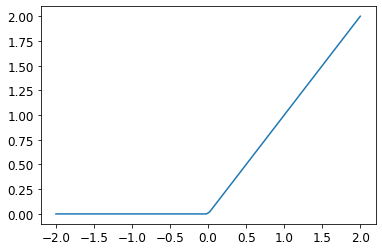

In [ ]:
plot_function(F.relu)

> J: There is an enormous amount of jargon in deep learning, including terms like _rectified linear unit_. The vast vast majority of this jargon is no more complicated than can be implemented in a short line of code, as we saw in this example. The reality is that for academics to get their papers published they need to make them sound as impressive and sophisticated as possible. One of the ways that they do that is to introduce jargon. Unfortunately, this has the result that the field ends up becoming far more intimidating and difficult to get into than it should be. You do have to learn the jargon, because otherwise papers and tutorials are not going to mean much to you. But that doesn't mean you have to find the jargon intimidating. Just remember, when you come across a word or phrase that you haven't seen before, it will almost certainly turn to be referring to a very simple concept.

> J: 在深度学习中有大量的行话，包括像 _ 整流线性单元 _ 这样的术语。正如我们在这个例子中看到的，绝大多数行话并不比在一小段代码中实现更复杂。现实情况是，为了让学者发表论文，他们需要让论文听起来尽可能令人印象深刻和复杂。他们这样做的方式之一是引入行话。不幸的是，这导致了这个领域变得更加令人生畏，难以进入。你必须学习行话，否则论文和教程对你来说不会有什么意义。但这并不意味着你必须觉得行话令人生畏。请记住，当你遇到一个你以前没见过的单词或短语时，它几乎肯定会变成一个非常简单的概念。[机器翻译]

The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions. But there's no point just putting one linear layout directly after another one, because when we multiply things together and then add them up multiple times, that could be replaced by multiplying different things together and adding them up just once! That is to say, a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.


基本的想法是，通过使用更多的线性层，我们可以让我们的模型做更多的计算，从而建模更复杂的函数。但是没有必要直接将一个线性布局放在另一个之后，因为当我们将事物相乘然后将它们相加多次时，这可以通过将不同的东西相乘并将它们相加一次来代替!也就是说，可以用具有不同参数集的单个线性层替换一行中任意数量的线性层。[机器翻译]

But if we put a nonlinear function between them, such as `max`, then this is no longer true. Now each linear layer is actually somewhat decoupled from the other ones, and can do its own useful work. The `max` function is particularly interesting, because it operates as a simple `if` statement.

但是如果我们在它们之间放一个非线性函数，比如 “max”，那么这就不再是真的了。现在，每个线性层实际上与其他层有些解耦，并且可以做自己有用的工作。“Max” 函数特别有趣，因为它作为一个简单的 “if” 语句运行。[机器翻译]

> S: Mathematically, we say the composition of two linear functions is another linear function. So, we can stack as many linear classifiers as we want on top of each other, and without nonlinear functions between them, it will just be the same as one linear classifier.

> S: 在数学上，我们说两个线性函数的组成是另一个线性函数。因此，我们可以在彼此之上堆叠任意多的线性分类器，如果它们之间没有非线性函数，它将与一个线性分类器相同。[机器翻译]

Amazingly enough, it can be mathematically proven that this little function can solve any computable problem to an arbitrarily high level of accuracy, if you can find the right parameters for `w1` and `w2` and if you make these matrices big enough. For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together; to make it closer to the wiggly function, we just have to use shorter lines. This is known as the *universal approximation theorem*. The three lines of code that we have here are known as *layers*. The first and third are known as *linear layers*, and the second line of code is known variously as a *nonlinearity*, or *activation function*.


令人惊讶的是，数学上可以证明这个小函数可以解决任何可计算的问题，达到任意高的精度，如果你能为 'w1' 和 'w2' 找到正确的参数，如果你让这些矩阵足够大。对于任何任意摆动函数，我们可以将其近似为一堆连接在一起的线; 为了使它更接近摆动函数，我们只需要使用较短的线。这被称为 * 普遍逼近定理 *。我们这里的三行代码被称为 * 层 *。第一个和第三个被称为 * 线性层 *，第二行代码被不同地称为 * 非线性 * 或 * 激活函数 *。[机器翻译]

Just like in the previous section, we can replace this code with something a bit simpler, by taking advantage of PyTorch:

就像上一节一样，我们可以利用PyTorch将这段代码替换为更简单的代码:[机器翻译]

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

`nn.Sequential` creates a module that will call each of the listed layers or functions in turn.


'Nn.Sequential' 创建一个模块，该模块将依次调用每个列出的层或函数。[机器翻译]

`nn.ReLU` is a PyTorch module that does exactly the same thing as the `F.relu` function. Most functions that can appear in a model also have identical forms that are modules. Generally, it's just a case of replacing `F` with `nn` and changing the capitalization. When using `nn.Sequential`, PyTorch requires us to use the module version. Since modules are classes, we have to instantiate them, which is why you see `nn.ReLU()` in this example. 


'Nn.Relu' 是一个PyTorch模块，它执行与 'f.Relu' 函数完全相同的操作。大多数可以出现在模型中的函数也具有相同的模块形式。一般来说，这只是用 “nn” 替换 “f” 并改变大写的情况。在使用 'nn.Sequential' 时，PyTorch要求我们使用模块版本。由于模块是类，我们必须实例化它们，这就是为什么在这个例子中看到 “nn.ReLU()”。[机器翻译]

Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Let's try it out! As this is a deeper model, we'll use a lower learning rate and a few more epochs.

因为 “nn.Sequential” 是一个模块，我们可以得到它的参数，它将返回它包含的所有模块的所有参数的列表。让我们试试吧!由于这是一个更深层次的模型，我们将使用较低的学习率和更多的时代。[机器翻译]

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
#hide_output
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.305828,0.399663,0.508341,00:00
1,0.142960,0.225702,0.807655,00:00
2,0.079516,0.113519,0.919529,00:00
3,0.052391,0.076792,0.943081,00:00
4,0.039796,0.060083,0.956330,00:00
5,0.033368,0.050713,0.963690,00:00
6,0.029680,0.044797,0.965653,00:00
7,0.027290,0.040729,0.968106,00:00
8,0.025568,0.037771,0.968597,00:00
9,0.024233,0.035508,0.970559,00:00


We're not showing the 40 lines of output here to save room; the training process is recorded in `learn.recorder`, with the table of output stored in the `values` attribute, so we can plot the accuracy over training as:

我们没有在这里显示40行输出以节省空间; 培训过程记录在 “学习” 中。recorder，输出表存储在 “values” 属性中，因此我们可以将训练的准确性绘制为:[机器翻译]

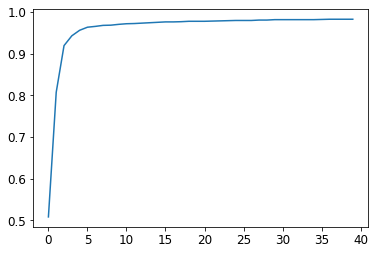

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

And we can view the final accuracy:

我们可以查看最终的准确性:[机器翻译]

In [ ]:
learn.recorder.values[-1][2]

0.982826292514801

At this point we have something that is rather magical:


在这一点上，我们有一些相当神奇的东西:[机器翻译]

1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
1. A way to find the best set of parameters for any function (stochastic gradient descent)


1.一个函数，可以解决任何问题的任何级别的精度 (神经网络) 给定正确的参数集
1.找到任何函数的最佳参数集的方法 (随机梯度下降)[机器翻译]

This is why deep learning can do things which seem rather magical such fantastic things. Believing that this combination of simple techniques can really solve any problem is one of the biggest steps that we find many students have to take. It seems too good to be true—surely things should be more difficult and complicated than this? Our recommendation: try it out! We just tried it on the MNIST dataset and you have seen the results. And since we are doing everything from scratch ourselves (except for calculating the gradients) you know that there is no special magic hiding behind the scenes.

这就是为什么深度学习可以做一些看起来相当神奇的事情。相信这种简单技术的组合可以真正解决任何问题是我们发现许多学生必须采取的最大步骤之一。这似乎太好了，不可能是真的 -- 当然事情应该比这更困难和复杂？我们的推荐: 尝试一下!我们刚刚在MNIST数据集上尝试过，您已经看到了结果。因为我们自己从头开始做所有的事情 (除了计算梯度)，你知道幕后隐藏着没有什么特别的魔法。[机器翻译]

### Going Deeper

# 深入[机器翻译]

There is no need to stop at just two linear layers. We can add as many as we want, as long as we add a nonlinearity between each pair of linear layers. As you will learn, however, the deeper the model gets, the harder it is to optimize the parameters in practice. Later in this book you will learn about some simple but brilliantly effective techniques for training deeper models.


不需要只停留在两个线性层。我们可以添加任意数量，只要我们在每对线性层之间添加非线性。然而，正如您将了解的那样，模型越深，在实践中优化参数就越难。在本书的后面，你将学习一些简单但非常有效的技术来训练更深层次的模型。[机器翻译]

We already know that a single nonlinearity with two linear layers is enough to approximate any function. So why would we use deeper models? The reason is performance. With a deeper model (that is, one with more layers) we do not need to use as many parameters; it turns out that we can use smaller matrices with more layers, and get better results than we would get with larger matrices, and few layers.


我们已经知道，具有两个线性层的单个非线性足以近似任何函数。那么我们为什么要使用更深的模型呢？原因是表现。对于更深的模型 (即具有更多层的模型)，我们不需要使用那么多参数; 事实证明，我们可以使用具有更多层的较小矩阵，获得比我们在更大的矩阵和几层中获得的更好的结果。[机器翻译]

That means that we can train the model more quickly, and it will take up less memory. In the 1990s researchers were so focused on the universal approximation theorem that very few were experimenting with more than one nonlinearity. This theoretical but not practical foundation held back the field for years. Some researchers, however, did experiment with deep models, and eventually were able to show that these models could perform much better in practice. Eventually, theoretical results were developed which showed why this happens. Today, it is extremely unusual to find anybody using a neural network with just one nonlinearity.


这意味着我们可以更快地训练模型，并且它将占用更少的内存。在20世纪90年代，研究人员如此专注于普遍逼近定理，以至于很少有人尝试不止一个非线性。这种理论而非实践的基础阻碍了这个领域多年。然而，一些研究人员做了深层模型的实验，最终能够证明这些模型在实践中表现得更好。最终，理论结果得到了发展，这表明了为什么会发生这种情况。今天，发现任何人使用只有一个非线性的神经网络是非常不寻常的。[机器翻译]

Here what happens when we train an 18-layer model using the same approach we saw in <<chapter_intro>>:

在这里，当我们使用我们在 <<chapter_intro>> 中看到的相同方法训练18层模型时会发生什么:[机器翻译]

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.082089,0.009578,0.997056,00:11


Nearly 100% accuracy! That's a big difference compared to our simple neural net. But as you'll learn in the remainder of this book, there are just a few little tricks you need to use to get such great results from scratch yourself. You already know the key foundational pieces. (Of course, even once you know all the tricks, you'll nearly always want to work with the pre-built classes provided by PyTorch and fastai, because they save you having to think about all the little details yourself.)

接近100% 的准确度!与我们简单的神经网络相比，这是一个很大的不同。但是正如你将在本书的其余部分学到的，你只需要使用一些小技巧就可以从零开始获得如此好的结果。你已经知道了关键的基础部分。(当然，即使你知道了所有的技巧，你也几乎总是想使用PyTorch和fastai提供的预构建类，因为它们让你不必自己考虑所有的小细节。)[机器翻译]

## Jargon Recap

# # 行话回顾[机器翻译]

Congratulations: you now know how to create and train a deep neural network from scratch! We've gone through quite a few steps to get to this point, but you might be surprised at how simple it really is.


恭喜: 您现在知道如何从头开始创建和训练深度神经网络了!我们已经经历了相当多的步骤来达到这一点，但是你可能会惊讶于它是如此简单。[机器翻译]

Now that we are at this point, it is a good opportunity to define, and review, some jargon and key concepts.


现在我们已经到了这一步，这是一个定义和回顾一些行话和关键概念的好机会。[机器翻译]

A neural network contains a lot of numbers, but they are only of two types: numbers that are calculated, and the parameters that these numbers are calculated from. This gives us the two most important pieces of jargon to learn:


神经网络包含许多数字，但它们只有两种类型: 计算的数字和计算这些数字的参数。这给了我们两个最重要的行话来学习:[机器翻译]

- Activations:: Numbers that are calculated (both by linear and nonlinear layers)
- Parameters:: Numbers that are randomly initialized, and optimized (that is, the numbers that define the model)


-Activations:: 计算的数字 (通过线性和非线性层)
-Parameters:: 随机初始化和优化的数字 (即定义模型的数字)[机器翻译]

We will often talk in this book about activations and parameters. Remember that they have very specific meanings. They are numbers. They are not abstract concepts, but they are actual specific numbers that are in your model. Part of becoming a good deep learning practitioner is getting used to the idea of actually looking at your activations and parameters, and plotting them and testing whether they are behaving correctly.


我们将经常在这本书中谈论激活和参数。记住它们有非常具体的含义。它们是数字。它们不是抽象的概念，但它们是模型中的实际特定数字。成为一名优秀的深度学习实践者的一部分是习惯于实际观察你的激活和参数，并对它们进行绘图和测试它们的行为是否正确。[机器翻译]

Our activations and parameters are all contained in *tensors*. These are simply regularly shaped arrays—for example, a matrix. Matrices have rows and columns; we call these the *axes* or *dimensions*. The number of dimensions of a tensor is its *rank*. There are some special tensors:


我们的激活和参数都包含在 * tensor * 中。这些是简单的规则形状的阵列-例如，一个矩阵。矩阵有行和列; 我们称之为 * 轴 * 或 * 维度 *。张量的维度数就是它的 * rank *。有一些特殊的张量:[机器翻译]

- Rank zero: scalar
- Rank one: vector
- Rank two: matrix


-等级零: 标量
-排名一: 矢量
-排名二: 矩阵[机器翻译]

A neural network contains a number of layers. Each layer is either *linear* or *nonlinear*. We generally alternate between these two kinds of layers in a neural network. Sometimes people refer to both a linear layer and its subsequent nonlinearity together as a single layer. Yes, this is confusing. Sometimes a nonlinearity is referred to as an *activation function*.


神经网络包含许多层。每一层是 * 线性 * 或 * 非线性 *。我们通常在神经网络中的这两种层之间交替。有时人们将线性层及其随后的非线性一起称为单层。是的，这令人困惑。有时非线性被称为 * 激活函数 *。[机器翻译]

<<dljargon1>> summarizes the key concepts related to SGD.


<<Dljargon1>> 总结了与SGD相关的关键概念。[机器翻译]

```asciidoc
[[dljargon1]]
.Deep learning vocabulary
[options="header"]
|=====
| Term | Meaning
|ReLU | Function that returns 0 for negative numbers and doesn't change positive numbers.
|Mini-batch | A smll group of inputs and labels gathered together in two arrays. A gradient descent step is updated on this batch (rather than a whole epoch).
|Forward pass | Applying the model to some input and computing the predictions.
|Loss | A value that represents how well (or badly) our model is doing.
|Gradient | The derivative of the loss with respect to some parameter of the model.
|Backard pass | Computing the gradients of the loss with respect to all model parameters.
|Gradient descent | Taking a step in the directions opposite to the gradients to make the model parameters a little bit better.
|Learning rate | The size of the step we take when applying SGD to update the parameters of the model.
|=====
```

'''Asciidoc
[[Dljargon1]]
。深度学习词汇
[Options = "header"]
|=====
| 术语 | 含义
| ReLU | 函数，对于负数返回0并且不改变正数。
| Mini-batch | 一组smll输入和标签聚集在两个数组中。在这个批次 (而不是整个纪元) 上更新梯度下降步骤。
| 向前传递 | 将模型应用于某些输入并计算预测。
| 损失 | 一个代表我们的模型做得多好 (或差) 的值。
| 梯度 | 损失相对于模型某个参数的导数。
| Backard pass | 计算损失相对于所有模型参数的梯度。
| 梯度下降 | 在与梯度相反的方向上走一步，使模型参数稍微好一点。
| 学习率 | 我们在应用SGD更新模型的参数时所采取的步骤的大小。
|=====
'''[机器翻译]

> note: _Choose Your Own Adventure_ Reminder: Did you choose to skip over chapters 2 & 3, in your excitement to peek under the hood? Well, here's your reminder to head back to chapter 2 now, because you'll be needing to know that stuff very soon!

> 注意: _ 选择你自己的冒险 _ 提醒: 你是否选择跳过第2章和第3章，在你兴奋的引擎盖下偷看？好吧，这是你现在回到第二章的提醒，因为你很快就需要知道这些东西![机器翻译]

## Questionnaire

# # 问卷调查[机器翻译]

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

1.灰度图像在计算机上是如何表示的？彩色图像怎么样？
1.“MNIST_SAMPLE” 数据集中的文件和文件夹是如何构造的？为什么？
1.解释分类数字的 “像素相似性” 方法是如何工作的。
1.什么是列表理解？现在创建一个从列表中选择奇数并使其加倍的数字。
1.什么是 “秩-3张量”？
1.张量等级和形状有什么不同？你如何从形状中获得等级？
1.什么是RMSE和L1范数？
1.如何一次对数千个数字进行计算，比Python循环快数千倍？
1.创建一个包含从1到9的数字的3 × 3张量或数组。加倍它。选择右下角的四个数字。
1.什么是广播？
1.通常是使用训练集还是验证集来计算指标？为什么？
1.什么是SGD？
1.SGD为什么使用小批量？
1.SGD中用于机器学习的七个步骤是什么？
1.我们如何初始化模型中的权重？
1.什么是 “损失”？
1.为什么我们不能总是使用高学习率？
1.什么是 “梯度”？
1.你需要知道如何自己计算梯度吗？
1.为什么我们不能用精度作为损失函数？
1.绘制sigmoid函数。它的形状有什么特别之处？
1.损失函数和度量的区别是什么？
1.使用学习速率计算新权重的函数是什么？
1.'dataloader' 类做什么？
1.编写伪代码，显示每个时代为SGD采取的基本步骤。
1.创建一个函数，如果传递了两个参数 '[1,2，3,4]' 和 ''abcd ''，则返回 '[(1，' a ')，(2，' b ')，(3，' c ')，(4，' d ')]'。该输出数据结构有什么特别之处？
1.“视图” 在PyTorch中做什么？
1.神经网络中的 “偏差” 参数是什么？我们为什么需要它们？
1.@ 在Python中，运算符是做什么的？
1.'backward' 方法是做什么的？
1.为什么我们必须将梯度归零？
1.我们必须向 “学习者” 传递什么信息？
1.显示训练循环的基本步骤的Python或伪代码。
1.什么是 “ReLU”？为从 '-2' 到 '2' 的值绘制一个绘图。
1.什么是 “激活函数”？
1.F.Relu和nn.Relu有什么区别？
1.普遍逼近定理表明，仅使用一个非线性就可以根据需要尽可能接近任何函数。那么为什么我们通常使用更多？[机器翻译]

### Further Research

# 进一步研究[机器翻译]

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.

1.根据本章所示的培训循环，从头开始创建您自己的 “学习者” 实现。
1.使用完整的MNIST数据集完成本章中的所有步骤 (即，对于所有数字，而不仅仅是3s和7s)。这是一个重要的项目，将花费你相当多的时间来完成!你需要做一些你自己的研究来找出如何克服你在路上遇到的一些障碍。[机器翻译]